In [ ]:
batch_size = int(2e5)
# batch_size_score = int(1e5) #int(2e5)
executor_instances = 5
max_batch_size = int(2e7)
max_score_batch_size = int(5e5)
baucket_size = int(11e6) #8.5
executor_cores = 1
executor_memory = 8

import os
import sys

if 'sc' in globals():
    sc.stop()

sys.path.insert(0, os.path.abspath('../../../utils'))
spark_home = '/opt/cloudera/parcels/SPARK2/lib/spark2'
os.environ['SPARK_HOME'] = spark_home
os.environ['PYSPARK_DRIVER_PYTHON'] = '/opt/venvs/anaconda/bin/python'
os.environ['PYSPARK_PYTHON'] = '/opt/venvs/anaconda/bin/python'
os.environ['LD_LIBRARY_PATH'] = '/opt/python/virtualenv/jupyter/|lib'
sys.path.insert(0, os.path.join (spark_home,'python'))
sys.path.insert(0, os.path.join (spark_home,'python/lib/py4j-0.10.7-src.zip'))

In [2]:

from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('cltv_refit_2').\
    setMaster("yarn-client").\
    set('spark.yarn.appMasterEnv.ARROW_PRE_0_15_IPC_FORMAT', 1).\
    set('spark.executorEnv.ARROW_PRE_0_15_IPC_FORMAT',1).\
    set('spark.local.dir', 'sparktmp').\
    set('spark.executor.memory','{}g'.format(executor_memory)).\
    set('spark.executor.instances', '{}'.format(executor_instances)).\
    set('spark.port.maxRetries', '500').\
    set('spark.executor.cores', '{}'.format(executor_cores)).\
    set('spark.dynamicAllocation.enabled', 'false').\
    set('spark.network.timeout', '700').\
    set("spark.sql.execution.arrow.enabled","true").\
    set("spark.kryoserializer.buffer.max", '2047mb').\
    set("spark.driver.memory",'7g').\
    set("spark.driver.cores", '4').\
    set("spark.dynamicAllocation.enabled", "false").\
    set("hive.exec.dynamic.partition", "true").\
    set("hive.exec.dynamic.partition.mode", "nonstrict").\
    set("spark.sql.execution.arrow.maxRecordsPerBatch", '{}'.format(batch_size)).\
    set("spark.sql.sources.bucketing.maxBuckets", '{}'.format(baucket_size)).\
    set("have.merge.sparkfiles", "true").\
    set("spark.files.overwrite", "true")

#set('spark.sql.execution.arrow.fallback.enabled', 'false')
#set('spark.worker.cleanup.enabled', 'true') #тогда не будут сохраняться файлы
#set('spark.driver.maxResultSize','10g').\
# set("hive.exec.dynamic.partition", "true").\
# set("hive.exec.dynamic.partition.mode", "nonstrict")
# 'spark.sql.execution.arrow.fallback.enabled' is set to true.

sc = SparkContext.getOrCreate(conf=conf).addFile(f'{os.getcwd()}/dspl.zip')
exec(open(os.path.join(spark_home, 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.0.cloudera2
      /_/

Using Python version 3.7.2 (default, Dec 29 2018 06:19:36)
SparkSession available as 'spark'.


In [3]:
import warnings
warnings.filterwarnings('ignore')

import gc, socket, joblib, os, re, sys, subprocess, numpy as np, pandas as pd, random as rd, pickle, pexpect, zipfile, shutil
import random as rd
from typing import Dict
from datetime import datetime as dt
from openpyxl import load_workbook
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from dspl.models import classifiers
from dspl.feature_extraction import transformers
from dspl.feature_extraction.utils import select_subset_features, drop_features
from dspl.validation_report.ValidationReporter import ValidationReporter
from dspl.reports.report import ClassificationDevelopmentReport
from dspl.utils import choose_psi_sample, get_input, INFOSaver
from dspl.validation import DataSplitter
from dspl.downcast import safe_compress_data

from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window

from IPython.display import display, HTML

exec(open('../cltv_spark_and_hive_funcs/cltv_spark_and_hive_funcs.py').read())

runpath = '/opt/workspace/yakovlev-ra_ca-sbrf-ru/runs/'
ssh_user = 'yakovlev-ra_ca-sbrf-ru'
nd_host = socket.gethostname() #нода, на которую сохраняем файл
pwd_file = f'/opt/workspace/{ssh_user}/pwd.txt'

In [4]:
config = {}


In [5]:
config['hue_db_for_traning'] = 'cltv_refit_2021'

config.update({
    'data_path': '/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/Data',
    'base_products': ['ap',], 
    "target_name": 'TRG'
})

In [6]:
config["targets_prepared"] = '{}_targets_{}_{}'

# название столбцов, которые не участвуют в обучении
config["drop_features"] = ['client_dk', 'report_dt','sd_doc_type_id', 'seg_crm_client_mgr_login_name', 'seg_crd_txn_mcc_cluster_id', 'lbt_lst_payroll_agrmnt_id', 'cmpn_doc_type_id', 'cmpn_loyal_control_group_id', 'cmpn_sms_operator_id', 'crd_cc_lst_plastic_type_id', 'crd_dc_lst_plastic_type_id', 'crd_main_card_dwh_id', 'prd_lst_prod_division_dk', 'prd_1st_prod_division_dk', 'lbt_acct_max_bal_division_dk', 'lbt_acct_lst_division_dk', 'lbt_acct_1st_division_dk', 'ext_stop_list_reason_rk', 'tp_lst_division_dk', 'lbt_payroll_agrmnt_nbr', 'sd_doc_type_name', 'seg_crd_txn_mcc_cluster_name', 'prd_lst_prod_tb_name', 'prd_1st_prod_tb_name', 'ext_stop_list_reason_name', 'crd_cc_mnth_snc_issue_frac', 'lbt_social_disab_pension', 'prd_city_lst_prod', 'ext_employee_dzo', 'cmpn_ctzshp_cntry_name', 'cmpn_sms_city_name', 'cmpn_sms_dlvr_time_intr_name', 'cmpn_sms_tz_msk_shift', 'cmpn_sms_tz_utc_shift', 'crd_cc_lst_plastic_type_name', 'crd_dc_lst_plastic_type_name', 'dep_lbt_acct_lst_division_dk', 'lbt_payroll_tax_payer_cd']\
    +['crd_otf_total_qty_12a', 'crd_otf_total_qty_6a', 'crd_inf_total_qty_12a', 'crd_otf_total_qty_3a', 'crd_inf_total_qty_3a', 'crd_inf_total_qty_6a']

# категориальные признаки, добавление опционально
config["categorical_features_full"] = ['seg_age_segment', 'Product', 'sd_gender_cd', 'sd_mdm_status_cd', 'sd_name_age_segment_cd', 'sd_stlmnt_type_cd', 'sd_stlmnt_type2_cd', 'seg_crm_segment_cd', 'seg_client_ret_segment_cd', 'seg_calc_segment_cd', 'seg_client_segment_cd', 'seg_client_segment_prev_cd', 'prd_lst_prod_tb_cd', 'prd_lst_prod_osb_cd', 'prd_lst_prod_vsp_cd', 'prd_lst_prod_cd', 'prd_1st_prod_tb_cd', 'prd_1st_prod_osb_cd', 'prd_1st_prod_vsp_cd', 'prd_1st_prod_cd', 'prd_client_type_final_cd', 'prd_client_type_final_prev_cd', 'prd_activity_status_cd', 'prd_activity_status_prev_cd', 'lbt_acct_max_bal_tb_cd', 'lbt_acct_max_bal_osb_cd', 'lbt_acct_max_bal_vsp_cd', 'crd_lst_agrmnt_tb_cd', 'crd_lst_agrmnt_osb_cd', 'crd_lst_agrmnt_vsp_cd', 'cred_cred_hist_cd', 'tp_active_kind_cd', 'tp_best_kind_ever_cd', 'tp_lst_tb_cd', 'tp_lst_kind_cd', 'prd_activity_status_1m_cd', 'prd_activity_status_prev_1m_cd', 'lbt_payroll_tax_payer_cd', 'seg_service_channel_cd', 'sd_name_age_segment2_cd', 'cmpn_dm_addr_src_cd', 'cmpn_email_src_cd', 'cmpn_seg_client_ret_segment_cd', 'cmpn_sms_operator_net_cd', 'crd_cc_lst_ips_cd', 'crd_dc_lst_ips_cd', 'seg_crd_segm_special_cd', 'seg_crd_segm_special_prev_cd', 'seg_premier_cd', 'sd_client_valid_nflag', 'sd_doc_valid_nflag', 'sd_russian_citizen_nflag', 'sd_resident_nflag', 'sd_sbrf_employee_nflag', 'seg_private_banking_nflag', 'prd_dc_active_nflag', 'prd_dc_active_prev_nflag', 'prd_cc_active_nflag', 'prd_cc_active_prev_nflag', 'prd_ma_active_nflag', 'prd_ma_active_prev_nflag', 'prd_da_active_nflag', 'prd_da_active_prev_nflag', 'prd_sc_active_nflag', 'prd_sc_active_prev_nflag', 'prd_pl_active_nflag', 'prd_pl_active_prev_nflag', 'prd_mg_active_nflag', 'prd_mg_active_prev_nflag', 'prd_ib_active_nflag', 'prd_ib_active_prev_nflag', 'prd_mb_active_nflag', 'prd_mb_active_prev_nflag', 'prd_ap_cell_active_nflag', 'prd_ap_cell_active_prev_nflag', 'prd_ap_utl_active_nflag', 'prd_ap_utl_active_prev_nflag', 'prd_ap_tlc_active_nflag', 'prd_ap_tlc_active_prev_nflag', 'prd_ap_loan_active_nflag', 'prd_ap_loan_active_prev_nflag', 'prd_ap_budg_active_nflag', 'prd_ap_budg_active_prev_nflag', 'prd_ap_othr_active_nflag', 'prd_ap_othr_active_prev_nflag', 'prd_ap_cnbx_active_nflag', 'prd_ap_cnbx_active_prev_nflag', 'prd_ap_p2p_active_nflag', 'prd_ap_p2p_active_prev_nflag', 'prd_client_active_nflag', 'prd_client_active_prev_nflag', 'lbt_payroll_client_nflag', 'lbt_social_client_nflag', 'crd_dc_payroll_nflag', 'crd_dc_payroll_pmt_nflag', 'crd_dc_payroll_act_nflag', 'crd_dc_payroll_sbrf_act_nflag', 'crd_dc_social_nflag', 'crd_dc_social_pmt_nflag', 'crd_dc_social_act_nflag', 'crd_cc_overdue_nflag', 'crd_dc_ever_nflag', 'crd_cc_ever_nflag', 'cred_overdue_nflag', 'cred_intr_overdue_nflag', 'srv_thanks_nflag', 'srv_mb_nflag', 'srv_ap_cell_nflag', 'srv_ap_utl_nflag', 'srv_ap_tlc_nflag', 'srv_ap_loan_nflag', 'srv_ap_budg_nflag', 'srv_ap_othr_nflag', 'srv_ap_cnbx_nflag', 'srv_ap_p2p_nflag', 'srv_udbo_nflag', 'ext_stop_list_nflag', 'ext_dead_nflag', 'tp_active_nflag', 'tp_ever_nflag', 'prd_dc_active_1m_nflag', 'prd_cc_active_1m_nflag', 'prd_ib_active_1m_nflag', 'prd_mb_active_1m_nflag', 'prd_ap_cell_active_1m_nflag', 'prd_ap_utl_active_1m_nflag', 'prd_ap_tlc_active_1m_nflag', 'prd_ap_loan_active_1m_nflag', 'prd_ap_budg_active_1m_nflag', 'prd_ap_othr_active_1m_nflag', 'prd_ap_cnbx_active_1m_nflag', 'prd_ap_p2p_active_1m_nflag', 'prd_client_active_1m_nflag', 'prd_mf_active_nflag', 'prd_mf_active_prev_nflag', 'srv_sbol_1m_login_nflag', 'srv_sbol_3m_login_nflag', 'srv_sbol_web_1m_login_nflag', 'srv_sbol_web_3m_login_nflag', 'srv_sbol_mob_1m_login_nflag', 'srv_sbol_mob_3m_login_nflag', 'srv_sbol_atm_1m_login_nflag', 'srv_sbol_atm_3m_login_nflag', 'seg_mvs_nflag', 'crd_open_nflag', 'crd_ever_nflag', 'ppc_crd_dc_active_1m_nflag', 'ppc_crd_dc_active_nflag', 'ppc_crd_cc_active_1m_nflag', 'ppc_crd_cc_active_nflag', 'ppc_mb_active_1m_nflag', 'ppc_mb_active_nflag', 'ppc_p2p_active_1m_nflag', 'ppc_p2p_active_nflag', 'ppc_pay_active_1m_nflag', 'ppc_pay_active_nflag', 'lne_ovd_overdue_nflag', 'cmpn_cb_staff_nflag', 'cla_all_active_nflag', 'cred_overdue_nflag_3m', 'cred_intr_overdue_nflag_3m', 'cred_overdue_nflag_6m', 'cred_intr_overdue_nflag_6m', 'cred_overdue_nflag_12m', 'cred_intr_overdue_nflag_12m', 'cmpn_blogger_nflag', 'cmpn_cell_phone_mbk_nflag', 'cmpn_client_contact_nflag', 'cmpn_client_eligible_nflag', 'cmpn_comm_champion_nflag', 'cmpn_control_group_nflag', 'cmpn_cross_chnl_clnt_nflag', 'cmpn_dm_avail_nflag', 'cmpn_doc_fms_invalid_nflag', 'cmpn_doc_unique_nflag', 'cmpn_email_avail_nflag', 'cmpn_friends_nflag', 'cmpn_householder_VIP_nflag', 'cmpn_mdm_bad_fio_nflag', 'cmpn_mdm_bad_gender_nflag', 'cmpn_mdm_cell_phone_mbk_nflag', 'cmpn_mdm_sms_avail_nflag', 'cmpn_nflag_cbc_stop_list_nflag', 'cmpn_nflag_empl_16_plus', 'cmpn_nflag_empl_DZO_flag', 'cmpn_portf_control_group_nflag', 'cmpn_potential_vip_nflag', 'cmpn_public_person_nflag', 'cmpn_sms_avail_nflag', 'cmpn_stop_list_nflag', 'cmpn_tm_avail_nflag', 'cmpn_tpin_avail_nflag', 'cmpn_true_stop_list_nflag', 'crd_cc_open_mc_nflag', 'crd_cc_open_mir_nflag', 'crd_cc_open_visa_nflag', 'crd_dc_open_mc_nflag', 'crd_dc_open_mir_nflag', 'crd_dc_open_visa_nflag', 'crd_mc_open_nflag', 'crd_visa_open_nflag', 'cred_coborrower_nflag', 'cred_cred_hist_bad_nflag', 'cred_cred_hist_good_nflag', 'cred_cred_hist_med_nflag', 'cred_cred_hist_none_nflag', 'cred_litigation_nflag', 'cred_open_nflag', 'cred_restructured_nflag', 'dep_pop_act_nflag', 'dep_pop_exp_2m_nflag', 'dep_pop_exp_3m_nflag', 'dep_sohr_exp_2m_nflag', 'dep_sohr_exp_3m_nflag', 'dep_upr_exp_2m_nflag', 'dep_upr_exp_3m_nflag', 'seg_prd_ap_avail_nflag', 'seg_prd_mb_full_avail_nflag', 'seg_prd_mb_otd_avail_nflag', 'seg_prd_mb_own_avail_nflag', 'seg_prd_mb_p2p_avail_nflag', 'seg_prd_sbol_tip_avail_nflag', 'seg_prd_sbol_web_avail_nflag', 'seg_prd_smart_avail_nflag', 'seg_prd_uko_avail_nflag', 'srv_ap_cell_dc_nflag', 'srv_mb_dc_nflag', 'srv_mb_quick_service_nflag', 'prd_dc_activity_ind', 'prd_cc_activity_ind', 'prd_ma_activity_ind', 'prd_da_activity_ind', 'prd_sc_activity_ind', 'prd_pl_activity_ind', 'prd_mg_activity_ind', 'prd_ib_activity_ind', 'prd_mb_activity_ind', 'prd_ap_cell_activity_ind', 'prd_ap_utl_activity_ind', 'prd_ap_tlc_activity_ind', 'prd_ap_loan_activity_ind', 'prd_ap_budg_activity_ind', 'prd_ap_othr_activity_ind', 'prd_ap_cnbx_activity_ind', 'prd_ap_p2p_activity_ind', 'prd_client_activity_ind', 'prd_dc_activity_1m_ind', 'prd_cc_activity_1m_ind', 'prd_ib_activity_1m_ind', 'prd_mb_activity_1m_ind', 'prd_ap_cell_activity_1m_ind', 'prd_ap_utl_activity_1m_ind', 'prd_ap_tlc_activity_1m_ind', 'prd_ap_loan_activity_1m_ind', 'prd_ap_budg_activity_1m_ind', 'prd_ap_othr_activity_1m_ind', 'prd_ap_cnbx_activity_1m_ind', 'prd_ap_p2p_activity_1m_ind', 'prd_client_activity_1m_ind', 'prd_mf_activity_ind', 'cmpn_prev_seg_crd_trx_segm', 'cmpn_prev_seg_crd_trx_subsegm', 'cmpn_random_group1_ind', 'cmpn_seg_crd_pos_cat_group', 'cmpn_seg_crd_trx_segm', 'cmpn_seg_crd_trx_subsegm', 'cmpn_trx_segm_activity_ind', 'cmpn_trx_subsegm_activity_ind', 'cred_cred_hist_auto_max_ind', 'cred_cred_hist_auto_min_ind', 'cred_cred_hist_cc_max_ind', 'cred_cred_hist_cc_min_ind', 'cred_cred_hist_mg_max_ind', 'cred_cred_hist_mg_min_ind', 'cred_cred_hist_othr_max_ind', 'cred_cred_hist_othr_min_ind', 'cred_cred_hist_pl_max_ind', 'cred_cred_hist_pl_min_ind', 'cred_cred_hist_tot_max_ind', 'cred_cred_hist_tot_min_ind', 'ap', 'cc', 'ch', 'd33', 'dc', 'dep', 'dlcc', 'dnpr', 'h', 'hu', 'iis', 'mapp', 'mb', 'ph', 'pl', 'plg', 'pt', 'sbl', 'sc', 'sf', 'sh', 'sm', 'st', 't2f', 'th', 'seg_client_mp_segment_cd', 'prl_tax_payer_id', 'prd_crd_dc_active_nflag', 'prd_crd_cc_active_nflag', 'dep_payroll_client_nflag', 'dep_social_client_nflag', 'lne_loan_overdue_nflag', 'lne_loan_overdue_nflag', 'sd_dead_nflag', 'prd_crd_dc_active_1m_nflag', 'prd_crd_cc_active_1m_nflag', 'prd_crd_dc_active_1m_nflag', 'prd_crd_dc_active_nflag', 'prd_crd_cc_active_1m_nflag', 'prd_crd_cc_active_nflag', 'prd_p2p_active_1m_nflag', 'prd_p2p_active_nflag', 'prd_pay_active_1m_nflag', 'prd_pay_active_nflag', 'lne_overdraft_overdue_nflag', 'sd_cb_staff_nflag'] 

# + config["base_products"]
    
config["non_categorical_features"] = ['report_dt']

# параметры разбиения данных на train / valid / test
config["split_params"] = [0.6, 0.2, 0.2]
config["split_column"] = None
config["sort"] = None

    # параметры для отбора признаков
config["absolute_diff"] = 5
config["relative_diff"] = 10
config["valid_sample"] = "valid"

    # порог для отбора признаков по PSI
    # и выборка для расчета PSI
config["psi_threshold"] = 0.01
config["psi_sample"] = "OOT"

    # порог для отбора признаков по метрике Джини
config["gini_threshold"] = 5

# порог для отбора признаков на основе перестановок (см. документацию подробнее)
config["permutation_threshold"] = 0.1,

    # количество итераций оптимизатора гиперпараметров моделей
config["n_iterations"] = 25

config['n_jobs'] = 20

config["model_type"] = "binary_classification"
config["target_name"] = 'TRG'

#### LGB (если на train и oot не удаётся избежать расхождений)

#### fitting

In [7]:
seed = 42

trainsformer_path = f'/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/cltv_transformer_full_ld_20210113_3y.pkl'
transformer = joblib.load(trainsformer_path)

xgb_params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'reg_lambda': 12,
    'max_depth': 4,
    'gamma': 10,
    'nthread': 20,
    'seed': seed
}
cb_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'task_type': 'CPU',
    'verbose': 10,
    'max_depth': 5,
    'l2_leaf_reg': 100,
    'random_seed': 42,
    'boosting_type': 'Ordered'
}

psi_params = {
    "max_depth": 4,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "importance_type": "gain",
    "learning_rate": 0.1,
    "n_estimators": 1500,
    "reg_lambda": 95,
    "cat_l2": 95,
    "num_leaves": 16,
    "seed": seed,
} 


delta_scores = {
    "absolute_diff": config.get("absolute_diff", 5),
    "relative_diff": config.get("relative_diff", 10)
}
optional_params = {
    "delta_scores": delta_scores,
    "categorical_features": transformer.cat_features
}

In [8]:
allowed_features = ['crd_dc_mnth_snc_lst_open_qty', 'srv_mb_tot_act_qty', 'crd_trx_dc_cash_6m_qty', 'crd_otf_fee_rub_amt', 'srv_mb_tot_qty', 'srv_mb_full_qty', 'sd_age_yrs_frac_nv', 'srv_mb_mnth_lst_txn_qty', 'crd_otf_total_qty_12a', 'srv_mb_quick_service_nflag', 'crd_dc_open_mc_nflag', 'sd_age_yrs_comp_nv', 'crd_otf_fee_qty', 'sd_age_mnth_comp_nv', 'crd_dc_mnth_snc_open_qty', 'crd_dc_social_act_nflag', 'crd_dc_payroll_nflag', 'srv_mb_econ_qty', 'crd_dc_open_visa_nflag', 'crd_pos_telecom_3m_qty', 'srv_sbol_mnth_mob_lst_log_qty', 'srv_mb_mnth_1st_txn_qty', 'dep_social_client_nflag', 'crd_pos_telecom_rub_3m_amt', 'srv_sbol_mnth_1st_login_qty', 'srv_sbol_txn_mob_3m_qty', 'prd_p2p_active_1m_nflag', 'crd_otf_pos_atm_qty', 'srv_sbol_mnth_lst_txn_qty', 'srv_sbol_mnth_web_lst_log_qty', 'dep_payroll_client_nflag', 'crd_lst_agrmnt_osb_cd', 'prd_mg_active_qty', 'crd_inf_ext_transf_rub_amt', 'dep_topup_12m_avg_rub_amt', 'crd_txn_spnd_3m_amt', 'srv_sbol_txn_3m_amt', 'prd_pl_active_nflag', 'crd_cc_tot_credit_rub_amt', 'crd_dc_open_mir_nflag', 'crd_cc_act_qty', 'crd_lst_agrmnt_vsp_cd', 'crd_dc_tot_bal_rub_amt', 'seg_client_mp_segment_cd', 'sd_gender_cd', 'prd_pl_active_qty', 'crd_lst_agrmnt_tb_cd', 'prd_da_active_qty', 'prd_mnth_1st_prod_open_qty', 'crd_cc_ever_nflag', 'crd_trx_dc_cash_6m_amt', 'crd_otf_total_qty_6a', 'crd_otf_total_qty', 'crd_tot_act_spend_qty', 'crd_cc_tot_otb_rub_amt', 'prd_1st_prod_tb_cd', 'crd_dc_payroll_act_nflag', 'crd_otf_dc_cash_qty', 'EL14', 'crd_tot_act_qty', 'crd_dc_open_qty', 'prd_lst_prod_cd', 'srv_sbol_txn_3m_qty', 'prd_sc_active_nflag', 'crd_txn_snpd_pos_ever_qty', 'prd_lst_prod_tb_cd', 'dep_topup_12m_qty', 'srv_ap_cell_nflag', 'srv_sbol_web_1m_login_nflag', 'prd_client_active_prod_qty', 'tp_active_nflag', 'seg_age_segment', 'srv_sbol_mob_3m_login_nflag', 'EL13', 'crd_dc_act_qty', 'crd_otf_cash_sb_qty', 'crd_dc_social_pmt_nflag', 'crd_trx_spnd_pos_avg_3m_amt', 'srv_sbol_mnth_1st_txn_qty', 'crd_dc_social_nflag', 'tp_ever_nflag', 'crd_trx_dc_cash_6m_spnd_qty', 'crd_trx_spnd_cash_avg_3m_amt', 'srv_thanks_nflag', 'prd_mb_active_qty', 'prd_mf_active_nflag', 'prd_mg_active_nflag', 'prd_mnth_lst_prod_open_qty', 'prd_da_active_nflag', 'prd_client_active_prod_1m_qty', 'crd_trx_dc_cash_3m_qty', 'crd_inf_total_qty_12a', 'srv_ap_othr_nflag', 'crd_cc_issued_qty', 'prd_yrs_lst_open_qty', 'srv_sbol_mnth_atm_lst_log_qty', 'crd_cc_overdue_nflag', 'crd_inf_othr_qty', 'prd_ap_utl_active_nflag', 'crd_txn_spnd_3m_qty', 'srv_ap_utl_nflag', 'crd_dc_pos_telecom_rub_amt', 'prd_pay_active_1m_nflag', 'crd_otf_dc_total_rub_amt', 'crd_otf_trnf_pers_mb_rub_amt', 'prd_client_active_nflag', 'EL15', 'EL19', 'crd_inf_transfer_rub_amt', 'crd_inf_total_qty', 'crd_otf_total_rub_amt', 'sd_sbrf_employee_nflag', 'crd_otf_pos_spend_qty', 'crd_otf_dc_total_qty', 'prd_ib_active_1m_nflag', 'srv_ap_cell_qty', 'crd_pos_net_rub_amt', 'crd_trx_dc_pos_spnd_6m_amt', 'crd_inf_transfer_qty', 'crd_trx_dc_pos_spnd_3m_amt', 'crd_inf_ext_transf_qty', 'crd_trx_dc_cash_6m_spnd_amt', 'crd_trx_dc_pos_spnd_6m_qty', 'srv_ap_cell_mnth_lst_txn_qty', 'crd_inf_othr_rub_amt', 'prd_ap_utl_active_1m_nflag', 'crd_otf_pos_spend_rub_amt', 'crd_dc_payroll_pmt_nflag', 'prd_mb_active_nflag', 'srv_mb_nflag', 'sd_russian_citizen_nflag', 'dc', 'crd_otf_othr_qty', 'EL16', 'crd_otf_trnf_pers_qty', 'crd_otf_trnf_pers_rub_amt', 'prd_ib_active_nflag', 'lne_mg_issued_ever_rub_amt', 'lne_mg_debt_due_rub_amt', 'lne_tot_max_ovrd_ever_days', 'lne_mg_issued_open_rub_amt', 'lne_tot_debt_due_rub_amt', 'lne_tot_open_wavg_intr_rate', 'crd_cc_open_qty', 'crd_dc_lst_bal_rub_amt', 'crd_cc_open_mc_nflag', 'srv_ap_cnbx_nflag', 'crd_otf_trnf_org_rub_amt', 'crd_otf_trnf_org_qty', 'crd_dc_pos_groceries_rub_amt', 'srv_ap_tlc_nflag', 'crd_otf_pos_atm_rub_amt', 'crd_otf_othr_rub_amt', 'crd_otf_cash_sb_rub_amt', 'srv_udbo_nflag', 'EL12', 'crd_otf_cash_rub_amt', 'EL18', 'srv_sbol_web_3m_login_nflag', 'srv_thanks_mnth_qty', 'crd_otf_dc_pos_spend_rub_amt', 'srv_sbol_mnth_lst_login_qty', 'prd_ap_cell_active_nflag', 'dep_upr_tot_bal_rub_amt', 'dep_sohr_exp_3m_nflag', 'dep_upr_exp_2m_nflag', 'srv_sbol_mob_1m_login_nflag', 'prd_pay_active_nflag', 'dep_pop_tot_bal_rub_amt', 'sd_stlmnt_type_cd', 'srv_sbol_txn_1m_qty', 'srv_sbol_txn_1m_amt', 'srv_ap_budg_nflag', 'srv_sbol_atm_3m_login_nflag', 'srv_sbol_1m_login_nflag', 'crd_dc_mnth_payroll_act_qty', 'crd_pos_groceries_rub_3m_amt', 'crd_pos_special_3m_qty', 'crd_otf_total_qty_3a', 'crd_cc_tot_os_rub_amt', 'crd_dc_act_spend_qty', 'sd_resident_nflag', 'crd_pos_healthcare_rub_3m_amt', 'srv_sbol_atm_1m_login_nflag', 'prd_crd_cc_active_nflag', 'crd_otf_trnf_pers_mb_qty', 'seg_service_channel_cd', 'crd_inf_total_qty_3a', 'crd_dc_mnth_payroll_open_qty', 'crd_otf_cash_atm_rub_amt', 'crd_otf_cash_atm_qty', 'srv_ap_p2p_nflag', 'prd_crd_cc_active_1m_nflag', 'prd_ib_active_qty', 'crd_cc_open_visa_nflag', 'crd_cc_own_bal_rub_amt', 'crd_inf_total_qty_6a', 'dep_tot_exp_2m_bal_rub_amt', 'srv_sbol_txn_mob_3m_amt', 'crd_pos_eat_out_rub_3m_amt', 'crd_cc_act_spend_qty', 'crd_dc_pos_telecom_qty', 'prd_ap_othr_active_nflag', 'crd_cc_utilization_pct', 'crd_cc_tot_lim_rub_amt', 'lne_tot_issued_ever_rub_amt', 'prd_p2p_active_nflag', 'crd_pos_groceries_3m_qty', 'prd_ap_cnbx_active_nflag', 'EL17', 'crd_trx_dc_pos_spnd_3m_qty', 'srv_ap_loan_nflag', 'EL11', 'crd_inf_dc_total_rub_amt', 'lne_pl_debt_due_rub_amt', 'lne_pl_issued_ever_rub_amt', 'lne_pl_issued_open_rub_amt', 'lne_pl_agr_open_ever_qty', 'prd_client_type_final_cd', 'lne_mg_debt_os_rub_amt', 'lne_mg_agr_open_ever_qty', 'srv_sbol_3m_login_nflag', 'crd_pos_special_rub_3m_amt', 'sd_client_valid_nflag', 'crd_pos_eat_out_3m_qty', 'srv_sbol_txn_mob_1m_amt', 'lne_pl_debt_os_rub_amt', 'lne_tot_debt_os_rub_amt', 'crd_inf_total_rub_amt', 'lne_mg_agr_os_qty', 'crd_trx_dc_cash_3m_amt', 'dep_sohr_exp_2m_bal_rub_amt', 'prd_1st_prod_cd', 'lne_tot_issued_open_rub_amt', 'dep_pop_act_nflag', 'crd_otf_dc_cash_rub_amt', 'crd_dc_pos_groceries_qty', 'crd_otf_dc_pos_spend_qty', 'lne_pl_open_wavg_intr_rate', 'lne_pl_agr_clsd_00_ever_qty', 'lne_pl_agr_os_qty', 'crd_open_nflag', 'inv_tot_bal_rub_amt', 'lne_tot_agr_open_ever_qty', 'prd_ap_loan_active_nflag', 'lne_pl_max_ovrd_open_days', 'lne_tot_max_ovrd_open_days', 'dep_upr_exp_3m_nflag', 'crd_pos_auto_rub_3m_amt', 'prd_client_active_1m_nflag', 'dep_pop_exp_3m_bal_rub_amt', 'crd_otf_cash_qty', 'crd_inf_dc_total_qty']


In [9]:
len(allowed_features)

253

In [10]:
import dspl
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

def get_metrics(eval_sets, model):
    metrics = []
    metrics.append(eval_sets['train'][1].sum()/eval_sets['train'][1].count())
    for key in eval_sets.keys():
        metrics.append(
            2 * roc_auc_score(
                eval_sets[key][1], model.transform(eval_sets[key][0])
                ) - 1
        )
    return metrics

def get_parquets(name, general_sdf):
    name, name_local = name.split('/')[-1], name
    if not os.path.exists(name_local):
        os.system('hdfs dfs -rm -r -skipTrash {}'.format(name))
        general_sdf.select([
            col for col in list(
                (set(allowed_features)) \
                | set(['T', bp, config['target_name'], 'client_dk']))
            if col in general_sdf.columns
        ]).write.mode('overwrite').parquet(name)
        sh.hdfs('dfs', '-get', '{}'.format(name), '{}'.format("/".join(name_local.split("/"))))
        sh.hdfs('dfs', '-rm', '-r', '-skipTrash', '{}'.format(name))
    data = pd.read_parquet(name_local).astype('float64')
    data[[bp, 'T', config['target_name']]] = \
        data[[bp, 'T', config['target_name']]].astype('int', errors = 'ignore')
    os.system(f'rm -r {name_local}')
    return data

def save_eval_sets_to_prq(*args):
    for key, path in args:
        trg = pd.DataFrame(data = eval_sets[key][1], columns = [config['target_name']])
        pd.concat(
            [eval_sets[key][0], trg], 
            axis = 1)\
        .to_parquet(
            path,
            compression='gzip',
            index=None,
        )
        print(path, 'saved')

def read_eval_sets(path):
    df = pd.read_parquet(path)
    return df.drop(config['target_name'], 1), df[config['target_name']]

def get_sample(sdf, max_size):
    global bp
    sample_ratio = max_size/datasets_length[0]
    sdf = sdf.withColumn(
        'sample_col', F.concat(*[F.col(x).cast('string') for x in ('report_dt', bp, 'T', config['target_name'])])
    )
    un_vals = [x[0] for x in sdf[['sample_col']].distinct().collect()]
    sdf = sdf.sampleBy('sample_col', {un_val: sample_ratio for un_val in un_vals}, seed=seed)\
        .drop('sample_col')
    print(f'size of data reduced to {sdf.count()}')
    return sdf

max_size = int(3.5e6)

allowed_features = ['crd_dc_mnth_snc_lst_open_qty', 'srv_mb_tot_act_qty', 'crd_trx_dc_cash_6m_qty', 'crd_otf_fee_rub_amt', 'srv_mb_tot_qty', 'srv_mb_full_qty', 'sd_age_yrs_frac_nv', 'srv_mb_mnth_lst_txn_qty', 'crd_otf_total_qty_12a', 'srv_mb_quick_service_nflag', 'crd_dc_open_mc_nflag', 'sd_age_yrs_comp_nv', 'crd_otf_fee_qty', 'sd_age_mnth_comp_nv', 'crd_dc_mnth_snc_open_qty', 'crd_dc_social_act_nflag', 'crd_dc_payroll_nflag', 'srv_mb_econ_qty', 'crd_dc_open_visa_nflag', 'crd_pos_telecom_3m_qty', 'srv_sbol_mnth_mob_lst_log_qty', 'srv_mb_mnth_1st_txn_qty', 'dep_social_client_nflag', 'crd_pos_telecom_rub_3m_amt', 'srv_sbol_mnth_1st_login_qty', 'srv_sbol_txn_mob_3m_qty', 'prd_p2p_active_1m_nflag', 'crd_otf_pos_atm_qty', 'srv_sbol_mnth_lst_txn_qty', 'srv_sbol_mnth_web_lst_log_qty', 'dep_payroll_client_nflag', 'crd_lst_agrmnt_osb_cd', 'prd_mg_active_qty', 'crd_inf_ext_transf_rub_amt', 'dep_topup_12m_avg_rub_amt', 'crd_txn_spnd_3m_amt', 'srv_sbol_txn_3m_amt', 'prd_pl_active_nflag', 'crd_cc_tot_credit_rub_amt', 'crd_dc_open_mir_nflag', 'crd_cc_act_qty', 'crd_lst_agrmnt_vsp_cd', 'crd_dc_tot_bal_rub_amt', 'seg_client_mp_segment_cd', 'sd_gender_cd', 'prd_pl_active_qty', 'crd_lst_agrmnt_tb_cd', 'prd_da_active_qty', 'prd_mnth_1st_prod_open_qty', 'crd_cc_ever_nflag', 'crd_trx_dc_cash_6m_amt', 'crd_otf_total_qty_6a', 'crd_otf_total_qty', 'crd_tot_act_spend_qty', 'crd_cc_tot_otb_rub_amt', 'prd_1st_prod_tb_cd', 'crd_dc_payroll_act_nflag', 'crd_otf_dc_cash_qty', 'EL14', 'crd_tot_act_qty', 'crd_dc_open_qty', 'prd_lst_prod_cd', 'srv_sbol_txn_3m_qty', 'prd_sc_active_nflag', 'crd_txn_snpd_pos_ever_qty', 'prd_lst_prod_tb_cd', 'dep_topup_12m_qty', 'srv_ap_cell_nflag', 'srv_sbol_web_1m_login_nflag', 'prd_client_active_prod_qty', 'tp_active_nflag', 'seg_age_segment', 'srv_sbol_mob_3m_login_nflag', 'EL13', 'crd_dc_act_qty', 'crd_otf_cash_sb_qty', 'crd_dc_social_pmt_nflag', 'crd_trx_spnd_pos_avg_3m_amt', 'srv_sbol_mnth_1st_txn_qty', 'crd_dc_social_nflag', 'tp_ever_nflag', 'crd_trx_dc_cash_6m_spnd_qty', 'crd_trx_spnd_cash_avg_3m_amt', 'srv_thanks_nflag', 'prd_mb_active_qty', 'prd_mf_active_nflag', 'prd_mg_active_nflag', 'prd_mnth_lst_prod_open_qty', 'prd_da_active_nflag', 'prd_client_active_prod_1m_qty', 'crd_trx_dc_cash_3m_qty', 'crd_inf_total_qty_12a', 'srv_ap_othr_nflag', 'crd_cc_issued_qty', 'prd_yrs_lst_open_qty', 'srv_sbol_mnth_atm_lst_log_qty', 'crd_cc_overdue_nflag', 'crd_inf_othr_qty', 'prd_ap_utl_active_nflag', 'crd_txn_spnd_3m_qty', 'srv_ap_utl_nflag', 'crd_dc_pos_telecom_rub_amt', 'prd_pay_active_1m_nflag', 'crd_otf_dc_total_rub_amt', 'crd_otf_trnf_pers_mb_rub_amt', 'prd_client_active_nflag', 'EL15', 'EL19', 'crd_inf_transfer_rub_amt', 'crd_inf_total_qty', 'crd_otf_total_rub_amt', 'sd_sbrf_employee_nflag', 'crd_otf_pos_spend_qty', 'crd_otf_dc_total_qty', 'prd_ib_active_1m_nflag', 'srv_ap_cell_qty', 'crd_pos_net_rub_amt', 'crd_trx_dc_pos_spnd_6m_amt', 'crd_inf_transfer_qty', 'crd_trx_dc_pos_spnd_3m_amt', 'crd_inf_ext_transf_qty', 'crd_trx_dc_cash_6m_spnd_amt', 'crd_trx_dc_pos_spnd_6m_qty', 'srv_ap_cell_mnth_lst_txn_qty', 'crd_inf_othr_rub_amt', 'prd_ap_utl_active_1m_nflag', 'crd_otf_pos_spend_rub_amt', 'crd_dc_payroll_pmt_nflag', 'prd_mb_active_nflag', 'srv_mb_nflag', 'sd_russian_citizen_nflag', 'dc', 'crd_otf_othr_qty', 'EL16', 'crd_otf_trnf_pers_qty', 'crd_otf_trnf_pers_rub_amt', 'prd_ib_active_nflag', 'lne_mg_issued_ever_rub_amt', 'lne_mg_debt_due_rub_amt', 'lne_tot_max_ovrd_ever_days', 'lne_mg_issued_open_rub_amt', 'lne_tot_debt_due_rub_amt', 'lne_tot_open_wavg_intr_rate', 'crd_cc_open_qty', 'crd_dc_lst_bal_rub_amt', 'crd_cc_open_mc_nflag', 'srv_ap_cnbx_nflag', 'crd_otf_trnf_org_rub_amt', 'crd_otf_trnf_org_qty', 'crd_dc_pos_groceries_rub_amt', 'srv_ap_tlc_nflag', 'crd_otf_pos_atm_rub_amt', 'crd_otf_othr_rub_amt', 'crd_otf_cash_sb_rub_amt', 'srv_udbo_nflag', 'EL12', 'crd_otf_cash_rub_amt', 'EL18', 'srv_sbol_web_3m_login_nflag', 'srv_thanks_mnth_qty', 'crd_otf_dc_pos_spend_rub_amt', 'srv_sbol_mnth_lst_login_qty', 'prd_ap_cell_active_nflag', 'dep_upr_tot_bal_rub_amt', 'dep_sohr_exp_3m_nflag', 'dep_upr_exp_2m_nflag', 'srv_sbol_mob_1m_login_nflag', 'prd_pay_active_nflag', 'dep_pop_tot_bal_rub_amt', 'sd_stlmnt_type_cd', 'srv_sbol_txn_1m_qty', 'srv_sbol_txn_1m_amt', 'srv_ap_budg_nflag', 'srv_sbol_atm_3m_login_nflag', 'srv_sbol_1m_login_nflag', 'crd_dc_mnth_payroll_act_qty', 'crd_pos_groceries_rub_3m_amt', 'crd_pos_special_3m_qty', 'crd_otf_total_qty_3a', 'crd_cc_tot_os_rub_amt', 'crd_dc_act_spend_qty', 'sd_resident_nflag', 'crd_pos_healthcare_rub_3m_amt', 'srv_sbol_atm_1m_login_nflag', 'prd_crd_cc_active_nflag', 'crd_otf_trnf_pers_mb_qty', 'seg_service_channel_cd', 'crd_inf_total_qty_3a', 'crd_dc_mnth_payroll_open_qty', 'crd_otf_cash_atm_rub_amt', 'crd_otf_cash_atm_qty', 'srv_ap_p2p_nflag', 'prd_crd_cc_active_1m_nflag', 'prd_ib_active_qty', 'crd_cc_open_visa_nflag', 'crd_cc_own_bal_rub_amt', 'crd_inf_total_qty_6a', 'dep_tot_exp_2m_bal_rub_amt', 'srv_sbol_txn_mob_3m_amt', 'crd_pos_eat_out_rub_3m_amt', 'crd_cc_act_spend_qty', 'crd_dc_pos_telecom_qty', 'prd_ap_othr_active_nflag', 'crd_cc_utilization_pct', 'crd_cc_tot_lim_rub_amt', 'lne_tot_issued_ever_rub_amt', 'prd_p2p_active_nflag', 'crd_pos_groceries_3m_qty', 'prd_ap_cnbx_active_nflag', 'EL17', 'crd_trx_dc_pos_spnd_3m_qty', 'srv_ap_loan_nflag', 'EL11', 'crd_inf_dc_total_rub_amt', 'lne_pl_debt_due_rub_amt', 'lne_pl_issued_ever_rub_amt', 'lne_pl_issued_open_rub_amt', 'lne_pl_agr_open_ever_qty', 'prd_client_type_final_cd', 'lne_mg_debt_os_rub_amt', 'lne_mg_agr_open_ever_qty', 'srv_sbol_3m_login_nflag', 'crd_pos_special_rub_3m_amt', 'sd_client_valid_nflag', 'crd_pos_eat_out_3m_qty', 'srv_sbol_txn_mob_1m_amt', 'lne_pl_debt_os_rub_amt', 'lne_tot_debt_os_rub_amt', 'crd_inf_total_rub_amt', 'lne_mg_agr_os_qty', 'crd_trx_dc_cash_3m_amt', 'dep_sohr_exp_2m_bal_rub_amt', 'prd_1st_prod_cd', 'lne_tot_issued_open_rub_amt', 'dep_pop_act_nflag', 'crd_otf_dc_cash_rub_amt', 'crd_dc_pos_groceries_qty', 'crd_otf_dc_pos_spend_qty', 'lne_pl_open_wavg_intr_rate', 'lne_pl_agr_clsd_00_ever_qty', 'lne_pl_agr_os_qty', 'crd_open_nflag', 'inv_tot_bal_rub_amt', 'lne_tot_agr_open_ever_qty', 'prd_ap_loan_active_nflag', 'lne_pl_max_ovrd_open_days', 'lne_tot_max_ovrd_open_days', 'dep_upr_exp_3m_nflag', 'crd_pos_auto_rub_3m_amt', 'prd_client_active_1m_nflag', 'dep_pop_exp_3m_bal_rub_amt', 'crd_otf_cash_qty', 'crd_inf_dc_total_qty']
all_bps = [
    'ap', 'cc', 'ch', 'd33', 'dc1', 'dc2p', 'dep', 'dlcc', 'dnpr', 'h', 'iis', 'mapp', 'mb',
    'ph', 'pl', 'plg', 'pt', 'sc', 'sf', 'sh', 'sm', 'st', 't2f', 'raso', 'th',
]

sp_bps = [
    'ap', 'cc', 'ch', 'd33', 'dc', 'dep', 'dlcc', 'dnpr', 'h', 'hu', 'iis', 'mapp', 'mb',
    'ph', 'pl', 'plg', 'pt', 'sbl', 'sc', 'sf', 'sh', 'sm', 'st', 't2f', 'th'
]

nd_path = '/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts'
new_model_path = f'{nd_path}'

delta_scores = {
    "absolute_diff": config.get("absolute_diff", 5),
    "relative_diff": config.get("relative_diff", 10)
}
optional_params = {
    "delta_scores": delta_scores,
    "categorical_features": transformer.cat_features
}
r = read_hive_table
# r = lambda x: spark.read.parquet(
#     'hdfs://nsld3/user/hive/warehouse/{}.db/{}'.format(*x.split('.'))
# )

art_path =  os.path.join(nd_path, 'data')
datasets_path =  os.path.join(nd_path, 'datasets')

[os.mkdir(x) for x in (nd_path, art_path, datasets_path) if not os.path.exists(x)]

metrics_new_path = f'{nd_path}/metrics.xlsx'
metrics_new_cols = [
    'model', 'n_trgs_train', 'e_rate_new_train', 'gini_new_train',
    'gini_new_valid','gini_new_test', 'gini_new_try_oot'
]
if not os.path.exists(metrics_new_path):
    metrics_new = pd.DataFrame(
        columns = metrics_new_cols
    )
else:
    metrics_new = pd.read_excel(metrics_new_path)

config["categorical_features_full"] += all_bps

In [11]:
all_bps = ['okko']
# sp_bps = ['ap']
# couples_to_refit = [
#     'dlcc_ap'
# ]

fitting okko
loading psi features
psi_features cnt: 178
fitting okko_ap
val rep okko_ap already exists
fitting okko_cc
val rep okko_cc already exists
fitting okko_ch
val rep okko_ch already exists
fitting okko_d33
val rep okko_d33 already exists
fitting okko_dc
val rep okko_dc already exists
fitting okko_dep
val rep okko_dep already exists
fitting okko_dlcc
val rep okko_dlcc already exists
fitting okko_dnpr
val rep okko_dnpr already exists
fitting okko_h
val rep okko_h already exists
fitting okko_hu
t_limit: 0
okko_hu data length: [2000000, 2000000]
okko_hu data length: [2000000, 2000000]
loading eval sets..


100%|██████████| 182/182 [02:21<00:00,  1.28it/s]


Sat Feb 20 11:35:47 2021, start fitting LightGBM-Model,  train.shape: 1200000 rows, 170 cols.
Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.997775	valid_0's binary_logloss: 4.51381e-05	valid_1's auc: 0.972741	valid_1's binary_logloss: 3.47713e-05
[20]	valid_0's auc: 0.997775	valid_0's binary_logloss: 4.49104e-05	valid_1's auc: 0.972741	valid_1's binary_logloss: 3.46864e-05
[30]	valid_0's auc: 0.997775	valid_0's binary_logloss: 4.4688e-05	valid_1's auc: 0.972741	valid_1's binary_logloss: 3.46068e-05
[40]	valid_0's auc: 0.999188	valid_0's binary_logloss: 4.44706e-05	valid_1's auc: 0.972741	valid_1's binary_logloss: 3.4532e-05
[50]	valid_0's auc: 0.999188	valid_0's binary_logloss: 4.42577e-05	valid_1's auc: 0.972741	valid_1's binary_logloss: 3.44618e-05
[60]	valid_0's auc: 0.999188	valid_0's binary_logloss: 4.40488e-05	valid_1's auc: 0.972741	valid_1's binary_logloss: 3.43956e-05
[70]	valid_0's auc: 0.999188	valid_0's binary_logloss: 4.38438e-05	valid

100%|██████████| 182/182 [02:18<00:00,  1.31it/s]


Sat Feb 20 12:01:42 2021, start fitting LightGBM-Model,  train.shape: 1200000 rows, 170 cols.
Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.889536	valid_0's binary_logloss: 0.00156162	valid_1's auc: 0.853236	valid_1's binary_logloss: 0.00155641
[20]	valid_0's auc: 0.910098	valid_0's binary_logloss: 0.00149695	valid_1's auc: 0.867988	valid_1's binary_logloss: 0.00150921
[30]	valid_0's auc: 0.91818	valid_0's binary_logloss: 0.00145289	valid_1's auc: 0.877019	valid_1's binary_logloss: 0.00148509
[40]	valid_0's auc: 0.924447	valid_0's binary_logloss: 0.00141906	valid_1's auc: 0.876114	valid_1's binary_logloss: 0.0014705
[50]	valid_0's auc: 0.930972	valid_0's binary_logloss: 0.00139054	valid_1's auc: 0.875369	valid_1's binary_logloss: 0.0014624
[60]	valid_0's auc: 0.935883	valid_0's binary_logloss: 0.00136626	valid_1's auc: 0.874113	valid_1's binary_logloss: 0.00145902
[70]	valid_0's auc: 0.9399	valid_0's binary_logloss: 0.00134513	valid_1's auc: 0.8731

Sat Feb 20 12:04:31 2021, start fitting XGBoost-Model,  train.shape: 1200000 rows, 21 cols.
[12:04:33] WARNING: /workspace/src/learner.cc:480: 
Parameters: { categorical_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[20]	validation_0-auc:0.50000	validation_1-auc:0.50000
[30]	validation_0-auc:0.50000	validation_1-auc:0.50000
[40]	validation_0-auc:0.71432	validation_1-auc:0.69978
[50]	validation_0-auc:0.71575	validation_1-auc:0.70126
[60]	validation_0-auc:0.71604	validation_1-auc:0.70125
[70]	validation_0-

,model,n_trgs_train,e_rate_new_train,gini_new_train,gini_new_valid,gini_new_test,gini_new_try_oot
158,okko_iis,209,0.000174,0.842817,0.820756,0.74612,0.726105


Creating data statistics report...


  0%|          | 0/173 [00:00<?, ?it/s]

Func: validate, Execution time: 14.098 sec.
Calculating variables gini report...


Func: validate, Execution time: 65.405 sec.
Creating bins prediction report
Func: validate, Execution time: 40.935 sec.
Calculating Gini stability report...


Func: validate, Execution time: 15.524 sec.
Calculating permutation importance...


21it [00:10,  1.98it/s]


Func: validate, Execution time: 12.119 sec.
Calculating PSI...
Func: validate, Execution time: 27.337 sec.
Func: transform, Execution time: 175.697 sec.
fitting okko_mapp
t_limit: 0
okko_mapp data length: [2000000, 2000000]
okko_mapp data length: [2000000, 2000000]
preparing eval_sets for okko_mapp
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_mapp.pkl_train.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_mapp.pkl_test.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_mapp.pkl_valid.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_mapp.pkl_OOT.parquet saved


100%|██████████| 182/182 [02:20<00:00,  1.30it/s]


Sat Feb 20 12:35:06 2021, start fitting LightGBM-Model,  train.shape: 1200000 rows, 170 cols.
Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.910866	valid_0's binary_logloss: 0.0330499	valid_1's auc: 0.909495	valid_1's binary_logloss: 0.0330816
[20]	valid_0's auc: 0.913188	valid_0's binary_logloss: 0.0315437	valid_1's auc: 0.911226	valid_1's binary_logloss: 0.0315976
[30]	valid_0's auc: 0.914975	valid_0's binary_logloss: 0.0309855	valid_1's auc: 0.912399	valid_1's binary_logloss: 0.031075
[40]	valid_0's auc: 0.91604	valid_0's binary_logloss: 0.0307487	valid_1's auc: 0.912933	valid_1's binary_logloss: 0.0308628
[50]	valid_0's auc: 0.916811	valid_0's binary_logloss: 0.0306182	valid_1's auc: 0.91354	valid_1's binary_logloss: 0.0307527
[60]	valid_0's auc: 0.917672	valid_0's binary_logloss: 0.0305284	valid_1's auc: 0.914076	valid_1's binary_logloss: 0.0306876
[70]	valid_0's auc: 0.918087	valid_0's binary_logloss: 0.0304698	valid_1's auc: 0.914386	valid_1'

Sat Feb 20 12:39:04 2021, start fitting XGBoost-Model,  train.shape: 1200000 rows, 16 cols.
[12:39:06] WARNING: /workspace/src/learner.cc:480: 
Parameters: { categorical_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.89255	validation_1-auc:0.89315
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[10]	validation_0-auc:0.90660	validation_1-auc:0.90658
[20]	validation_0-auc:0.90883	validation_1-auc:0.90919
[30]	validation_0-auc:0.91098	validation_1-auc:0.91138
[40]	validation_0-auc:0.91499	validation_1-auc:0.91521
[50]	validation_0-auc:0.91800	validation_1-auc:0.91819
[60]	validation_0-auc:0.92100	validation_1-auc:0.92099
[70]	validation_0-

,model,n_trgs_train,e_rate_new_train,gini_new_train,gini_new_valid,gini_new_test,gini_new_try_oot
159,okko_mapp,8155,0.006796,0.852735,0.851169,0.84727,0.844244


Creating data statistics report...


  0%|          | 0/171 [00:00<?, ?it/s]

Func: validate, Execution time: 14.461 sec.
Calculating variables gini report...


Func: validate, Execution time: 64.391 sec.
Creating bins prediction report
Func: validate, Execution time: 43.686 sec.
Calculating Gini stability report...


Func: validate, Execution time: 11.056 sec.
Calculating permutation importance...


16it [00:08,  1.80it/s]


Func: validate, Execution time: 10.344 sec.
Calculating PSI...
Func: validate, Execution time: 25.742 sec.
Func: transform, Execution time: 169.936 sec.
fitting okko_mb
t_limit: 0
okko_mb data length: [2000000, 2000000]
okko_mb data length: [2000000, 2000000]
preparing eval_sets for okko_mb
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_mb.pkl_train.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_mb.pkl_test.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_mb.pkl_valid.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_mb.pkl_OOT.parquet saved


100%|██████████| 182/182 [02:27<00:00,  1.24it/s]


Sat Feb 20 13:11:21 2021, start fitting LightGBM-Model,  train.shape: 1200000 rows, 170 cols.
Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.679615	valid_0's binary_logloss: 0.237795	valid_1's auc: 0.674912	valid_1's binary_logloss: 0.23819
[20]	valid_0's auc: 0.687387	valid_0's binary_logloss: 0.234565	valid_1's auc: 0.682257	valid_1's binary_logloss: 0.235148
[30]	valid_0's auc: 0.692409	valid_0's binary_logloss: 0.23309	valid_1's auc: 0.68665	valid_1's binary_logloss: 0.233853
[40]	valid_0's auc: 0.696094	valid_0's binary_logloss: 0.232235	valid_1's auc: 0.689857	valid_1's binary_logloss: 0.233123
[50]	valid_0's auc: 0.69973	valid_0's binary_logloss: 0.231424	valid_1's auc: 0.693076	valid_1's binary_logloss: 0.232434
[60]	valid_0's auc: 0.701969	valid_0's binary_logloss: 0.230978	valid_1's auc: 0.694792	valid_1's binary_logloss: 0.232099
[70]	valid_0's auc: 0.704092	valid_0's binary_logloss: 0.230582	valid_1's auc: 0.696457	valid_1's binary_loglo

Sat Feb 20 13:25:24 2021, start fitting XGBoost-Model,  train.shape: 1200000 rows, 21 cols.
[13:25:25] WARNING: /workspace/src/learner.cc:480: 
Parameters: { categorical_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.68217	validation_1-auc:0.67960
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[10]	validation_0-auc:0.69294	validation_1-auc:0.68988
[20]	validation_0-auc:0.70161	validation_1-auc:0.69828
[30]	validation_0-auc:0.70872	validation_1-auc:0.70465
[40]	validation_0-auc:0.71409	validation_1-auc:0.70969
[50]	validation_0-auc:0.71867	validation_1-auc:0.71361
[60]	validation_0-auc:0.72291	validation_1-auc:0.71742
[70]	validation_0-

,model,n_trgs_train,e_rate_new_train,gini_new_train,gini_new_valid,gini_new_test,gini_new_try_oot
160,okko_mb,82117,0.068431,0.468405,0.453301,0.459314,0.44864


Creating data statistics report...


  0%|          | 0/169 [00:00<?, ?it/s]

Func: validate, Execution time: 15.442 sec.
Calculating variables gini report...


Func: validate, Execution time: 64.39 sec.
Creating bins prediction report
Func: validate, Execution time: 46.211 sec.
Calculating Gini stability report...


Func: validate, Execution time: 14.088 sec.
Calculating permutation importance...


21it [00:17,  1.23it/s]


Func: validate, Execution time: 18.906 sec.
Calculating PSI...
Func: validate, Execution time: 35.553 sec.
Func: transform, Execution time: 194.846 sec.
fitting okko_ph
t_limit: 0
okko_ph data length: [2000000, 2000000]
okko_ph data length: [2000000, 2000000]
preparing eval_sets for okko_ph
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_ph.pkl_train.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_ph.pkl_test.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_ph.pkl_valid.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_ph.pkl_OOT.parquet saved


100%|██████████| 182/182 [02:28<00:00,  1.23it/s]


Sat Feb 20 13:58:51 2021, start fitting LightGBM-Model,  train.shape: 1200000 rows, 170 cols.
Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.762109	valid_0's binary_logloss: 0.0169518	valid_1's auc: 0.759982	valid_1's binary_logloss: 0.0169156
[20]	valid_0's auc: 0.778342	valid_0's binary_logloss: 0.0166903	valid_1's auc: 0.771255	valid_1's binary_logloss: 0.01669
[30]	valid_0's auc: 0.784697	valid_0's binary_logloss: 0.0165385	valid_1's auc: 0.775253	valid_1's binary_logloss: 0.0165766
[40]	valid_0's auc: 0.7911	valid_0's binary_logloss: 0.0164284	valid_1's auc: 0.777939	valid_1's binary_logloss: 0.0165122
[50]	valid_0's auc: 0.796392	valid_0's binary_logloss: 0.0163463	valid_1's auc: 0.780472	valid_1's binary_logloss: 0.0164646
[60]	valid_0's auc: 0.801099	valid_0's binary_logloss: 0.0162729	valid_1's auc: 0.781664	valid_1's binary_logloss: 0.0164322
[70]	valid_0's auc: 0.805204	valid_0's binary_logloss: 0.016212	valid_1's auc: 0.783932	valid_1's 

Sat Feb 20 14:03:25 2021, start fitting XGBoost-Model,  train.shape: 1200000 rows, 21 cols.
[14:03:26] WARNING: /workspace/src/learner.cc:480: 
Parameters: { categorical_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[20]	validation_0-auc:0.69432	validation_1-auc:0.70964
[30]	validation_0-auc:0.78992	validation_1-auc:0.79824
[40]	validation_0-auc:0.79871	validation_1-auc:0.80146
[50]	validation_0-auc:0.80595	validation_1-auc:0.80589
[60]	validation_0-auc:0.81988	validation_1-auc:0.81972
[70]	validation_0-

,model,n_trgs_train,e_rate_new_train,gini_new_train,gini_new_valid,gini_new_test,gini_new_try_oot
161,okko_ph,3063,0.002553,0.695298,0.681495,0.680093,0.520603


Creating data statistics report...


  0%|          | 0/169 [00:00<?, ?it/s]

Func: validate, Execution time: 14.462 sec.
Calculating variables gini report...


Func: validate, Execution time: 62.466 sec.
Creating bins prediction report
Func: validate, Execution time: 44.404 sec.
Calculating Gini stability report...


Func: validate, Execution time: 13.374 sec.
Calculating permutation importance...


21it [00:14,  1.50it/s]


Func: validate, Execution time: 15.8 sec.
Calculating PSI...
Func: validate, Execution time: 34.676 sec.
Func: transform, Execution time: 185.447 sec.
fitting okko_pl
t_limit: 0
okko_pl data length: [2000000, 2000000]
okko_pl data length: [2000000, 2000000]
preparing eval_sets for okko_pl
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_pl.pkl_train.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_pl.pkl_test.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_pl.pkl_valid.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_pl.pkl_OOT.parquet saved


100%|██████████| 182/182 [02:31<00:00,  1.20it/s]


Sat Feb 20 14:36:18 2021, start fitting LightGBM-Model,  train.shape: 1200000 rows, 170 cols.
Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.843203	valid_0's binary_logloss: 0.0735683	valid_1's auc: 0.842087	valid_1's binary_logloss: 0.0737072
[20]	valid_0's auc: 0.847837	valid_0's binary_logloss: 0.0713852	valid_1's auc: 0.846398	valid_1's binary_logloss: 0.071582
[30]	valid_0's auc: 0.851296	valid_0's binary_logloss: 0.0705988	valid_1's auc: 0.849273	valid_1's binary_logloss: 0.0708651
[40]	valid_0's auc: 0.853969	valid_0's binary_logloss: 0.0701913	valid_1's auc: 0.85139	valid_1's binary_logloss: 0.0705144
[50]	valid_0's auc: 0.855647	valid_0's binary_logloss: 0.0699293	valid_1's auc: 0.852855	valid_1's binary_logloss: 0.0702854
[60]	valid_0's auc: 0.8572	valid_0's binary_logloss: 0.069712	valid_1's auc: 0.854094	valid_1's binary_logloss: 0.0701129
[70]	valid_0's auc: 0.858526	valid_0's binary_logloss: 0.0695401	valid_1's auc: 0.855024	valid_1's 

Sat Feb 20 14:45:51 2021, start fitting XGBoost-Model,  train.shape: 1200000 rows, 17 cols.
[14:45:53] WARNING: /workspace/src/learner.cc:480: 
Parameters: { categorical_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.79504	validation_1-auc:0.79502
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[10]	validation_0-auc:0.84505	validation_1-auc:0.84579
[20]	validation_0-auc:0.84980	validation_1-auc:0.85011
[30]	validation_0-auc:0.85330	validation_1-auc:0.85267
[40]	validation_0-auc:0.85815	validation_1-auc:0.85840
[50]	validation_0-auc:0.86234	validation_1-auc:0.86186
[60]	validation_0-auc:0.86557	validation_1-auc:0.86466
[70]	validation_0-

,model,n_trgs_train,e_rate_new_train,gini_new_train,gini_new_valid,gini_new_test,gini_new_try_oot
162,okko_pl,20654,0.017212,0.744823,0.740704,0.74225,0.729519


Creating data statistics report...


  0%|          | 0/171 [00:00<?, ?it/s]

Func: validate, Execution time: 14.367 sec.
Calculating variables gini report...


Func: validate, Execution time: 62.463 sec.
Creating bins prediction report
Func: validate, Execution time: 43.724 sec.
Calculating Gini stability report...


Func: validate, Execution time: 12.157 sec.
Calculating permutation importance...


17it [00:11,  1.47it/s]


Func: validate, Execution time: 13.189 sec.
Calculating PSI...
Func: validate, Execution time: 26.47 sec.
Func: transform, Execution time: 172.606 sec.
fitting okko_plg
t_limit: 0
okko_plg data length: [2000000, 2000000]
okko_plg data length: [2000000, 2000000]
preparing eval_sets for okko_plg
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_plg.pkl_train.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_plg.pkl_test.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_plg.pkl_valid.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_plg.pkl_OOT.parquet saved


100%|██████████| 182/182 [02:36<00:00,  1.16it/s]


Sat Feb 20 15:18:53 2021, start fitting LightGBM-Model,  train.shape: 1200000 rows, 170 cols.
Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.908759	valid_0's binary_logloss: 0.0230803	valid_1's auc: 0.903059	valid_1's binary_logloss: 0.023167
[20]	valid_0's auc: 0.915676	valid_0's binary_logloss: 0.0222156	valid_1's auc: 0.908208	valid_1's binary_logloss: 0.0223704
[30]	valid_0's auc: 0.919611	valid_0's binary_logloss: 0.0219334	valid_1's auc: 0.911894	valid_1's binary_logloss: 0.0221525
[40]	valid_0's auc: 0.922071	valid_0's binary_logloss: 0.021798	valid_1's auc: 0.913785	valid_1's binary_logloss: 0.0220675
[50]	valid_0's auc: 0.923636	valid_0's binary_logloss: 0.0216983	valid_1's auc: 0.914689	valid_1's binary_logloss: 0.0220192
[60]	valid_0's auc: 0.924859	valid_0's binary_logloss: 0.0216138	valid_1's auc: 0.915412	valid_1's binary_logloss: 0.0219918
[70]	valid_0's auc: 0.925854	valid_0's binary_logloss: 0.0215455	valid_1's auc: 0.915587	valid_1

Sat Feb 20 15:22:03 2021, start fitting XGBoost-Model,  train.shape: 1200000 rows, 9 cols.
[15:22:03] WARNING: /workspace/src/learner.cc:480: 
Parameters: { categorical_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.84337	validation_1-auc:0.84163
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[10]	validation_0-auc:0.84570	validation_1-auc:0.84335
[20]	validation_0-auc:0.89450	validation_1-auc:0.89186
[30]	validation_0-auc:0.90041	validation_1-auc:0.89829
[40]	validation_0-auc:0.90285	validation_1-auc:0.90069
[50]	validation_0-auc:0.90957	validation_1-auc:0.90639
[60]	validation_0-auc:0.92000	validation_1-auc:0.91796
[70]	validation_0-a

,model,n_trgs_train,e_rate_new_train,gini_new_train,gini_new_valid,gini_new_test,gini_new_try_oot
163,okko_plg,5692,0.004743,0.853087,0.847666,0.842733,0.842602


Creating data statistics report...


  0%|          | 0/171 [00:00<?, ?it/s]

Func: validate, Execution time: 13.404 sec.
Calculating variables gini report...


Func: validate, Execution time: 62.554 sec.
Creating bins prediction report
Func: validate, Execution time: 42.345 sec.
Calculating Gini stability report...


Func: validate, Execution time: 5.648 sec.
Calculating permutation importance...


9it [00:03,  2.34it/s]


Func: validate, Execution time: 4.992 sec.
Calculating PSI...
Func: validate, Execution time: 18.018 sec.
Func: transform, Execution time: 147.145 sec.
fitting okko_pt
t_limit: 0
okko_pt data length: [2000000, 2000000]
okko_pt data length: [2000000, 2000000]
preparing eval_sets for okko_pt
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_pt.pkl_train.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_pt.pkl_test.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_pt.pkl_valid.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_pt.pkl_OOT.parquet saved


100%|██████████| 182/182 [02:42<00:00,  1.12it/s]


Sat Feb 20 15:53:58 2021, start fitting LightGBM-Model,  train.shape: 1200000 rows, 170 cols.
Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.796618	valid_0's binary_logloss: 0.0149911	valid_1's auc: 0.784502	valid_1's binary_logloss: 0.0150408
[20]	valid_0's auc: 0.812468	valid_0's binary_logloss: 0.0146789	valid_1's auc: 0.79794	valid_1's binary_logloss: 0.014774
[30]	valid_0's auc: 0.82157	valid_0's binary_logloss: 0.0145222	valid_1's auc: 0.805416	valid_1's binary_logloss: 0.014653
[40]	valid_0's auc: 0.827257	valid_0's binary_logloss: 0.0144135	valid_1's auc: 0.808901	valid_1's binary_logloss: 0.0145888
[50]	valid_0's auc: 0.831704	valid_0's binary_logloss: 0.0143284	valid_1's auc: 0.810704	valid_1's binary_logloss: 0.0145436
[60]	valid_0's auc: 0.835452	valid_0's binary_logloss: 0.0142622	valid_1's auc: 0.811808	valid_1's binary_logloss: 0.0145168
[70]	valid_0's auc: 0.838369	valid_0's binary_logloss: 0.014204	valid_1's auc: 0.812812	valid_1's 

Sat Feb 20 15:58:00 2021, start fitting XGBoost-Model,  train.shape: 1200000 rows, 22 cols.
[15:58:01] WARNING: /workspace/src/learner.cc:480: 
Parameters: { categorical_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[10]	validation_0-auc:0.64931	validation_1-auc:0.65701
[20]	validation_0-auc:0.68513	validation_1-auc:0.68131
[30]	validation_0-auc:0.75615	validation_1-auc:0.75468
[40]	validation_0-auc:0.78707	validation_1-auc:0.78139
[50]	validation_0-auc:0.81625	validation_1-auc:0.80744
[60]	validation_0-auc:0.82868	validation_1-auc:0.81935
[70]	validation_0-

,model,n_trgs_train,e_rate_new_train,gini_new_train,gini_new_valid,gini_new_test,gini_new_try_oot
164,okko_pt,2792,0.002327,0.721895,0.694623,0.696575,0.680797


Creating data statistics report...


  0%|          | 0/167 [00:00<?, ?it/s]

Func: validate, Execution time: 14.205 sec.
Calculating variables gini report...


Func: validate, Execution time: 59.608 sec.
Creating bins prediction report
Func: validate, Execution time: 43.491 sec.
Calculating Gini stability report...


Func: validate, Execution time: 12.942 sec.
Calculating permutation importance...


22it [00:15,  1.47it/s]


Func: validate, Execution time: 16.829 sec.
Calculating PSI...
Func: validate, Execution time: 39.421 sec.
Func: transform, Execution time: 186.749 sec.
fitting okko_sbl
t_limit: 0
okko_sbl data length: [2000000, 2000000]
okko_sbl data length: [2000000, 2000000]
preparing eval_sets for okko_sbl
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_sbl.pkl_train.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_sbl.pkl_test.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_sbl.pkl_valid.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_sbl.pkl_OOT.parquet saved


100%|██████████| 182/182 [02:44<00:00,  1.11it/s]


Sat Feb 20 16:31:44 2021, start fitting LightGBM-Model,  train.shape: 1200000 rows, 170 cols.
Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.950155	valid_0's binary_logloss: 0.0117438	valid_1's auc: 0.947903	valid_1's binary_logloss: 0.0118067
[20]	valid_0's auc: 0.951634	valid_0's binary_logloss: 0.0111976	valid_1's auc: 0.948857	valid_1's binary_logloss: 0.0112804
[30]	valid_0's auc: 0.952832	valid_0's binary_logloss: 0.0110061	valid_1's auc: 0.949024	valid_1's binary_logloss: 0.0111114
[40]	valid_0's auc: 0.9542	valid_0's binary_logloss: 0.010915	valid_1's auc: 0.949644	valid_1's binary_logloss: 0.0110434
[50]	valid_0's auc: 0.954761	valid_0's binary_logloss: 0.0108616	valid_1's auc: 0.949776	valid_1's binary_logloss: 0.0110088
[60]	valid_0's auc: 0.955376	valid_0's binary_logloss: 0.01082	valid_1's auc: 0.949829	valid_1's binary_logloss: 0.0109892
[70]	valid_0's auc: 0.955998	valid_0's binary_logloss: 0.0107848	valid_1's auc: 0.950379	valid_1's 

Sat Feb 20 16:35:44 2021, start fitting XGBoost-Model,  train.shape: 1200000 rows, 7 cols.
[16:35:44] WARNING: /workspace/src/learner.cc:480: 
Parameters: { categorical_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.93438	validation_1-auc:0.93382
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[10]	validation_0-auc:0.93439	validation_1-auc:0.93384
[20]	validation_0-auc:0.93706	validation_1-auc:0.93597
[30]	validation_0-auc:0.94637	validation_1-auc:0.94738
[40]	validation_0-auc:0.94973	validation_1-auc:0.95096
[50]	validation_0-auc:0.95065	validation_1-auc:0.95168
[60]	validation_0-auc:0.95108	validation_1-auc:0.95209
[70]	validation_0-a

,model,n_trgs_train,e_rate_new_train,gini_new_train,gini_new_valid,gini_new_test,gini_new_try_oot
165,okko_sbl,2554,0.002128,0.906495,0.906573,0.908707,0.903


Creating data statistics report...


  0%|          | 0/172 [00:00<?, ?it/s]

Func: validate, Execution time: 12.61 sec.
Calculating variables gini report...


Func: validate, Execution time: 62.742 sec.
Creating bins prediction report
Func: validate, Execution time: 26.26 sec.
Calculating Gini stability report...


Func: validate, Execution time: 4.413 sec.
Calculating permutation importance...


7it [00:02,  2.74it/s]


Func: validate, Execution time: 3.509 sec.
Calculating PSI...
Func: validate, Execution time: 13.867 sec.
Func: transform, Execution time: 123.586 sec.
fitting okko_sc
t_limit: 0
okko_sc data length: [2000000, 2000000]
okko_sc data length: [2000000, 2000000]
preparing eval_sets for okko_sc
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_sc.pkl_train.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_sc.pkl_test.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_sc.pkl_valid.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_sc.pkl_OOT.parquet saved


100%|██████████| 182/182 [02:47<00:00,  1.08it/s]


Sat Feb 20 17:07:14 2021, start fitting LightGBM-Model,  train.shape: 1200000 rows, 170 cols.
Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.789249	valid_0's binary_logloss: 0.024614	valid_1's auc: 0.776633	valid_1's binary_logloss: 0.0247666
[20]	valid_0's auc: 0.800651	valid_0's binary_logloss: 0.024066	valid_1's auc: 0.788088	valid_1's binary_logloss: 0.0242739
[30]	valid_0's auc: 0.807675	valid_0's binary_logloss: 0.0237914	valid_1's auc: 0.793818	valid_1's binary_logloss: 0.0240624
[40]	valid_0's auc: 0.813195	valid_0's binary_logloss: 0.023616	valid_1's auc: 0.797895	valid_1's binary_logloss: 0.0239359
[50]	valid_0's auc: 0.817762	valid_0's binary_logloss: 0.0234826	valid_1's auc: 0.800415	valid_1's binary_logloss: 0.0238606
[60]	valid_0's auc: 0.821623	valid_0's binary_logloss: 0.0233641	valid_1's auc: 0.802274	valid_1's binary_logloss: 0.0237999
[70]	valid_0's auc: 0.824961	valid_0's binary_logloss: 0.0232684	valid_1's auc: 0.804168	valid_1'

Sat Feb 20 17:12:36 2021, start fitting XGBoost-Model,  train.shape: 1200000 rows, 22 cols.
[17:12:38] WARNING: /workspace/src/learner.cc:480: 
Parameters: { categorical_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[10]	validation_0-auc:0.70566	validation_1-auc:0.68824
[20]	validation_0-auc:0.75520	validation_1-auc:0.74117
[30]	validation_0-auc:0.78005	validation_1-auc:0.77089
[40]	validation_0-auc:0.80672	validation_1-auc:0.79827
[50]	validation_0-auc:0.82295	validation_1-auc:0.81448
[60]	validation_0-auc:0.83271	validation_1-auc:0.82481
[70]	validation_0-

,model,n_trgs_train,e_rate_new_train,gini_new_train,gini_new_valid,gini_new_test,gini_new_try_oot
166,okko_sc,4893,0.004078,0.706373,0.680819,0.68039,0.630018


Creating data statistics report...


  0%|          | 0/170 [00:00<?, ?it/s]

Func: validate, Execution time: 14.784 sec.
Calculating variables gini report...


Func: validate, Execution time: 63.225 sec.
Creating bins prediction report
Func: validate, Execution time: 46.084 sec.
Calculating Gini stability report...


Func: validate, Execution time: 15.634 sec.
Calculating permutation importance...


22it [00:15,  1.38it/s]


Func: validate, Execution time: 17.797 sec.
Calculating PSI...
Func: validate, Execution time: 33.509 sec.
Func: transform, Execution time: 191.29 sec.
fitting okko_sf
t_limit: 0
okko_sf data length: [2000000, 2000000]
okko_sf data length: [2000000, 2000000]
preparing eval_sets for okko_sf
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_sf.pkl_train.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_sf.pkl_test.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_sf.pkl_valid.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_sf.pkl_OOT.parquet saved


100%|██████████| 182/182 [02:51<00:00,  1.06it/s]


Sat Feb 20 17:46:53 2021, start fitting LightGBM-Model,  train.shape: 1200000 rows, 170 cols.
Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.935924	valid_0's binary_logloss: 0.0141915	valid_1's auc: 0.923886	valid_1's binary_logloss: 0.0144699
[20]	valid_0's auc: 0.939472	valid_0's binary_logloss: 0.0134439	valid_1's auc: 0.927743	valid_1's binary_logloss: 0.0138222
[30]	valid_0's auc: 0.942339	valid_0's binary_logloss: 0.013199	valid_1's auc: 0.929845	valid_1's binary_logloss: 0.0136649
[40]	valid_0's auc: 0.944173	valid_0's binary_logloss: 0.01309	valid_1's auc: 0.930273	valid_1's binary_logloss: 0.013614
[50]	valid_0's auc: 0.945283	valid_0's binary_logloss: 0.0130142	valid_1's auc: 0.930807	valid_1's binary_logloss: 0.0135809
[60]	valid_0's auc: 0.946231	valid_0's binary_logloss: 0.0129449	valid_1's auc: 0.930937	valid_1's binary_logloss: 0.0135696
[70]	valid_0's auc: 0.946811	valid_0's binary_logloss: 0.012888	valid_1's auc: 0.931021	valid_1's 

Sat Feb 20 17:50:40 2021, start fitting XGBoost-Model,  train.shape: 1200000 rows, 13 cols.
[17:50:41] WARNING: /workspace/src/learner.cc:480: 
Parameters: { categorical_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.84955	validation_1-auc:0.84418
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[10]	validation_0-auc:0.84986	validation_1-auc:0.84449
[20]	validation_0-auc:0.85001	validation_1-auc:0.84466
[30]	validation_0-auc:0.88596	validation_1-auc:0.87725
[40]	validation_0-auc:0.92455	validation_1-auc:0.91868
[50]	validation_0-auc:0.93990	validation_1-auc:0.93269
[60]	validation_0-auc:0.94304	validation_1-auc:0.93540
[70]	validation_0-

,model,n_trgs_train,e_rate_new_train,gini_new_train,gini_new_valid,gini_new_test,gini_new_try_oot
167,okko_sf,3959,0.003299,0.909483,0.889102,0.902265,0.866091


Creating data statistics report...


  0%|          | 0/172 [00:00<?, ?it/s]

Func: validate, Execution time: 13.937 sec.
Calculating variables gini report...


Func: validate, Execution time: 62.363 sec.
Creating bins prediction report
Func: validate, Execution time: 42.882 sec.
Calculating Gini stability report...


Func: validate, Execution time: 8.965 sec.
Calculating permutation importance...


13it [00:06,  1.90it/s]


Func: validate, Execution time: 8.186 sec.
Calculating PSI...
Func: validate, Execution time: 20.745 sec.
Func: transform, Execution time: 157.287 sec.
fitting okko_sh
t_limit: 0
okko_sh data length: [2000000, 2000000]
okko_sh data length: [2000000, 2000000]
preparing eval_sets for okko_sh
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_sh.pkl_train.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_sh.pkl_test.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_sh.pkl_valid.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_sh.pkl_OOT.parquet saved


100%|██████████| 182/182 [02:57<00:00,  1.03it/s]


Sat Feb 20 18:24:13 2021, start fitting LightGBM-Model,  train.shape: 1200000 rows, 170 cols.
Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.835823	valid_0's binary_logloss: 0.0070752	valid_1's auc: 0.838927	valid_1's binary_logloss: 0.00708224
[20]	valid_0's auc: 0.851212	valid_0's binary_logloss: 0.00680167	valid_1's auc: 0.847549	valid_1's binary_logloss: 0.0068497
[30]	valid_0's auc: 0.858486	valid_0's binary_logloss: 0.00666929	valid_1's auc: 0.853481	valid_1's binary_logloss: 0.00674315
[40]	valid_0's auc: 0.863419	valid_0's binary_logloss: 0.00658491	valid_1's auc: 0.854683	valid_1's binary_logloss: 0.00669394
[50]	valid_0's auc: 0.867102	valid_0's binary_logloss: 0.00652338	valid_1's auc: 0.855177	valid_1's binary_logloss: 0.00666654
[60]	valid_0's auc: 0.870439	valid_0's binary_logloss: 0.00647359	valid_1's auc: 0.855577	valid_1's binary_logloss: 0.00664806
[70]	valid_0's auc: 0.87322	valid_0's binary_logloss: 0.00643154	valid_1's auc: 0.85

Sat Feb 20 18:27:40 2021, start fitting XGBoost-Model,  train.shape: 1200000 rows, 21 cols.
[18:27:42] WARNING: /workspace/src/learner.cc:480: 
Parameters: { categorical_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[20]	validation_0-auc:0.59435	validation_1-auc:0.58452
[30]	validation_0-auc:0.68756	validation_1-auc:0.69712
[40]	validation_0-auc:0.74088	validation_1-auc:0.77217
[50]	validation_0-auc:0.81539	validation_1-auc:0.82918
[60]	validation_0-auc:0.82836	validation_1-auc:0.83911
[70]	validation_0-

,model,n_trgs_train,e_rate_new_train,gini_new_train,gini_new_valid,gini_new_test,gini_new_try_oot
168,okko_sh,1162,0.000968,0.743368,0.739153,0.710304,0.714337


Creating data statistics report...


  0%|          | 0/173 [00:00<?, ?it/s]

Func: validate, Execution time: 14.208 sec.
Calculating variables gini report...


Func: validate, Execution time: 63.41 sec.
Creating bins prediction report
Func: validate, Execution time: 44.364 sec.
Calculating Gini stability report...


Func: validate, Execution time: 16.21 sec.
Calculating permutation importance...


21it [00:12,  1.72it/s]


Func: validate, Execution time: 13.879 sec.
Calculating PSI...
Func: validate, Execution time: 28.537 sec.
Func: transform, Execution time: 180.854 sec.
fitting okko_sm
t_limit: 0
okko_sm data length: [2000000, 2000000]
okko_sm data length: [2000000, 2000000]
preparing eval_sets for okko_sm
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_sm.pkl_train.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_sm.pkl_test.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_sm.pkl_valid.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_sm.pkl_OOT.parquet saved


100%|██████████| 182/182 [03:04<00:00,  1.01s/it]


Sat Feb 20 19:01:49 2021, start fitting LightGBM-Model,  train.shape: 1200000 rows, 170 cols.
Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.795133	valid_0's binary_logloss: 0.00746128	valid_1's auc: 0.751768	valid_1's binary_logloss: 0.00755431
[20]	valid_0's auc: 0.812505	valid_0's binary_logloss: 0.00723399	valid_1's auc: 0.76325	valid_1's binary_logloss: 0.00740053
[30]	valid_0's auc: 0.823367	valid_0's binary_logloss: 0.007104	valid_1's auc: 0.770813	valid_1's binary_logloss: 0.00733325
[40]	valid_0's auc: 0.830966	valid_0's binary_logloss: 0.00701826	valid_1's auc: 0.773133	valid_1's binary_logloss: 0.00730165
[50]	valid_0's auc: 0.837959	valid_0's binary_logloss: 0.00695176	valid_1's auc: 0.777299	valid_1's binary_logloss: 0.00727499
[60]	valid_0's auc: 0.844034	valid_0's binary_logloss: 0.00689404	valid_1's auc: 0.778002	valid_1's binary_logloss: 0.00726458
[70]	valid_0's auc: 0.849486	valid_0's binary_logloss: 0.00684698	valid_1's auc: 0.77

Sat Feb 20 19:05:28 2021, start fitting XGBoost-Model,  train.shape: 1200000 rows, 13 cols.
[19:05:29] WARNING: /workspace/src/learner.cc:480: 
Parameters: { categorical_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[10]	validation_0-auc:0.60663	validation_1-auc:0.59608
[20]	validation_0-auc:0.60663	validation_1-auc:0.59608
[30]	validation_0-auc:0.60718	validation_1-auc:0.59649
[40]	validation_0-auc:0.60727	validation_1-auc:0.59654
[50]	validation_0-auc:0.75030	validation_1-auc:0.74320
[60]	validation_0-auc:0.79398	validation_1-auc:0.78298
[70]	validation_0-

,model,n_trgs_train,e_rate_new_train,gini_new_train,gini_new_valid,gini_new_test,gini_new_try_oot
169,okko_sm,1216,0.001013,0.640835,0.606605,0.626937,0.520562


Creating data statistics report...


  0%|          | 0/172 [00:00<?, ?it/s]

Func: validate, Execution time: 13.734 sec.
Calculating variables gini report...


Func: validate, Execution time: 65.123 sec.
Creating bins prediction report
Func: validate, Execution time: 40.975 sec.
Calculating Gini stability report...


Func: validate, Execution time: 9.133 sec.
Calculating permutation importance...


13it [00:06,  2.00it/s]


Func: validate, Execution time: 7.778 sec.
Calculating PSI...
Func: validate, Execution time: 19.882 sec.
Func: transform, Execution time: 157.023 sec.
fitting okko_st
t_limit: 0
okko_st data length: [2000000, 2000000]
okko_st data length: [2000000, 2000000]
preparing eval_sets for okko_st
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_st.pkl_train.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_st.pkl_test.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_st.pkl_valid.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_st.pkl_OOT.parquet saved


100%|██████████| 182/182 [03:02<00:00,  1.00s/it]


Sat Feb 20 19:41:22 2021, start fitting LightGBM-Model,  train.shape: 1200000 rows, 170 cols.
Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.805552	valid_0's binary_logloss: 0.00456409	valid_1's auc: 0.739363	valid_1's binary_logloss: 0.00461098
[20]	valid_0's auc: 0.816251	valid_0's binary_logloss: 0.00448006	valid_1's auc: 0.748437	valid_1's binary_logloss: 0.00455903
[30]	valid_0's auc: 0.825835	valid_0's binary_logloss: 0.00442515	valid_1's auc: 0.757215	valid_1's binary_logloss: 0.00452685
[40]	valid_0's auc: 0.832718	valid_0's binary_logloss: 0.00438657	valid_1's auc: 0.762793	valid_1's binary_logloss: 0.00450689
[50]	valid_0's auc: 0.83976	valid_0's binary_logloss: 0.0043547	valid_1's auc: 0.765465	valid_1's binary_logloss: 0.00449486
[60]	valid_0's auc: 0.846284	valid_0's binary_logloss: 0.0043257	valid_1's auc: 0.768965	valid_1's binary_logloss: 0.00448468
[70]	valid_0's auc: 0.852867	valid_0's binary_logloss: 0.00429705	valid_1's auc: 0.77

Sat Feb 20 19:44:54 2021, start fitting XGBoost-Model,  train.shape: 1200000 rows, 21 cols.
[19:44:56] WARNING: /workspace/src/learner.cc:480: 
Parameters: { categorical_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[20]	validation_0-auc:0.50000	validation_1-auc:0.50000
[30]	validation_0-auc:0.50000	validation_1-auc:0.50000
[40]	validation_0-auc:0.50000	validation_1-auc:0.50000
[50]	validation_0-auc:0.77122	validation_1-auc:0.75583
[60]	validation_0-auc:0.81809	validation_1-auc:0.80259
[70]	validation_0-

,model,n_trgs_train,e_rate_new_train,gini_new_train,gini_new_valid,gini_new_test,gini_new_try_oot
170,okko_st,673,0.000561,0.70696,0.658747,0.663702,0.584088


Creating data statistics report...


  0%|          | 0/172 [00:00<?, ?it/s]

Func: validate, Execution time: 13.853 sec.
Calculating variables gini report...


Func: validate, Execution time: 63.371 sec.
Creating bins prediction report
Func: validate, Execution time: 41.89 sec.
Calculating Gini stability report...


Func: validate, Execution time: 15.1 sec.
Calculating permutation importance...


21it [00:11,  1.81it/s]


Func: validate, Execution time: 13.317 sec.
Calculating PSI...
Func: validate, Execution time: 28.732 sec.
Func: transform, Execution time: 176.518 sec.
fitting okko_t2f
t_limit: 0
okko_t2f data length: [2000000, 2000000]
okko_t2f data length: [2000000, 2000000]
preparing eval_sets for okko_t2f
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_t2f.pkl_train.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_t2f.pkl_test.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_t2f.pkl_valid.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_t2f.pkl_OOT.parquet saved


100%|██████████| 182/182 [03:04<00:00,  1.01s/it]


Sat Feb 20 20:19:34 2021, start fitting LightGBM-Model,  train.shape: 1200000 rows, 170 cols.
Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.879075	valid_0's binary_logloss: 0.00220839	valid_1's auc: 0.786962	valid_1's binary_logloss: 0.00226527
[20]	valid_0's auc: 0.893121	valid_0's binary_logloss: 0.00210801	valid_1's auc: 0.80093	valid_1's binary_logloss: 0.00220943
[30]	valid_0's auc: 0.902393	valid_0's binary_logloss: 0.00204272	valid_1's auc: 0.808664	valid_1's binary_logloss: 0.00217602
[40]	valid_0's auc: 0.907138	valid_0's binary_logloss: 0.00199922	valid_1's auc: 0.813421	valid_1's binary_logloss: 0.00215729
[50]	valid_0's auc: 0.911596	valid_0's binary_logloss: 0.00196449	valid_1's auc: 0.818961	valid_1's binary_logloss: 0.00214526
[60]	valid_0's auc: 0.914888	valid_0's binary_logloss: 0.00193775	valid_1's auc: 0.821725	valid_1's binary_logloss: 0.00213884
[70]	valid_0's auc: 0.918735	valid_0's binary_logloss: 0.00191263	valid_1's auc: 0.

Sat Feb 20 20:22:29 2021, start fitting XGBoost-Model,  train.shape: 1200000 rows, 21 cols.
[20:22:31] WARNING: /workspace/src/learner.cc:480: 
Parameters: { categorical_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[20]	validation_0-auc:0.50000	validation_1-auc:0.50000
[30]	validation_0-auc:0.57991	validation_1-auc:0.57046
[40]	validation_0-auc:0.68583	validation_1-auc:0.67988
[50]	validation_0-auc:0.68728	validation_1-auc:0.68166
[60]	validation_0-auc:0.83359	validation_1-auc:0.77450
[70]	validation_0-

,model,n_trgs_train,e_rate_new_train,gini_new_train,gini_new_valid,gini_new_test,gini_new_try_oot
171,okko_t2f,310,0.000258,0.0,0.0,0.0,0.0


Creating data statistics report...


  0%|          | 0/172 [00:00<?, ?it/s]

Func: validate, Execution time: 13.49 sec.
Calculating variables gini report...


Func: validate, Execution time: 60.01 sec.
Creating bins prediction report
Func: validate, Execution time: 7.184 sec.
Calculating Gini stability report...


Func: validate, Execution time: 13.837 sec.
Calculating permutation importance...


21it [00:08,  2.35it/s]


Func: validate, Execution time: 10.348 sec.
Calculating PSI...
Func: validate, Execution time: 26.729 sec.
Func: transform, Execution time: 131.823 sec.
fitting okko_th
t_limit: 0
okko_th data length: [2000000, 2000000]
okko_th data length: [2000000, 2000000]
preparing eval_sets for okko_th
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_th.pkl_train.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_th.pkl_test.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_th.pkl_valid.parquet saved
/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/data/eval_sets_okko_th.pkl_OOT.parquet saved


100%|██████████| 182/182 [03:06<00:00,  1.02s/it]


Sat Feb 20 20:55:50 2021, start fitting LightGBM-Model,  train.shape: 1200000 rows, 170 cols.
Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.87305	valid_0's binary_logloss: 0.0311919	valid_1's auc: 0.86983	valid_1's binary_logloss: 0.0312876
[20]	valid_0's auc: 0.876636	valid_0's binary_logloss: 0.0302478	valid_1's auc: 0.871999	valid_1's binary_logloss: 0.0304002
[30]	valid_0's auc: 0.87926	valid_0's binary_logloss: 0.0299241	valid_1's auc: 0.874054	valid_1's binary_logloss: 0.0301156
[40]	valid_0's auc: 0.881513	valid_0's binary_logloss: 0.02976	valid_1's auc: 0.875617	valid_1's binary_logloss: 0.0299987
[50]	valid_0's auc: 0.883202	valid_0's binary_logloss: 0.0296637	valid_1's auc: 0.876166	valid_1's binary_logloss: 0.0299565
[60]	valid_0's auc: 0.884558	valid_0's binary_logloss: 0.0295916	valid_1's auc: 0.87669	valid_1's binary_logloss: 0.0299304
[70]	valid_0's auc: 0.885687	valid_0's binary_logloss: 0.0295291	valid_1's auc: 0.876979	valid_1's b

Sat Feb 20 20:59:57 2021, start fitting XGBoost-Model,  train.shape: 1200000 rows, 13 cols.
[20:59:58] WARNING: /workspace/src/learner.cc:480: 
Parameters: { categorical_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.82306	validation_1-auc:0.82146
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[10]	validation_0-auc:0.86150	validation_1-auc:0.86000
[20]	validation_0-auc:0.86361	validation_1-auc:0.86206
[30]	validation_0-auc:0.86790	validation_1-auc:0.86562
[40]	validation_0-auc:0.87148	validation_1-auc:0.86919
[50]	validation_0-auc:0.88057	validation_1-auc:0.87706
[60]	validation_0-auc:0.88408	validation_1-auc:0.88021
[70]	validation_0-

,model,n_trgs_train,e_rate_new_train,gini_new_train,gini_new_valid,gini_new_test,gini_new_try_oot
172,okko_th,7131,0.005942,0.78266,0.773163,0.777177,0.779063


Creating data statistics report...


  0%|          | 0/171 [00:00<?, ?it/s]

Func: validate, Execution time: 13.201 sec.
Calculating variables gini report...


Func: validate, Execution time: 58.74 sec.
Creating bins prediction report
Func: validate, Execution time: 41.132 sec.
Calculating Gini stability report...


Func: validate, Execution time: 8.306 sec.
Calculating permutation importance...


13it [00:06,  1.86it/s]


Func: validate, Execution time: 8.318 sec.
Calculating PSI...
Func: validate, Execution time: 20.784 sec.
Func: transform, Execution time: 150.677 sec.


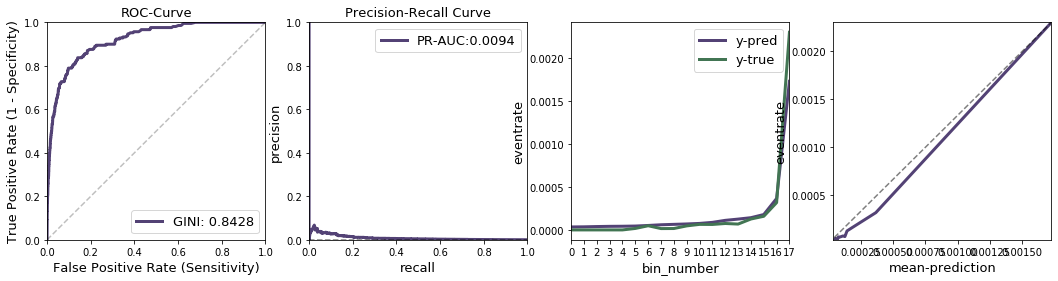

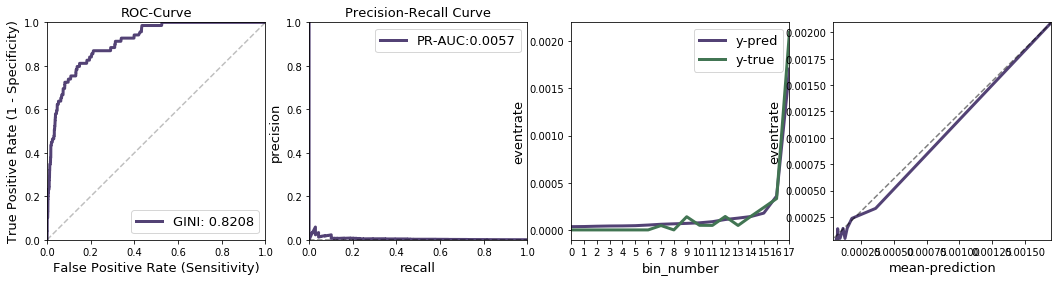

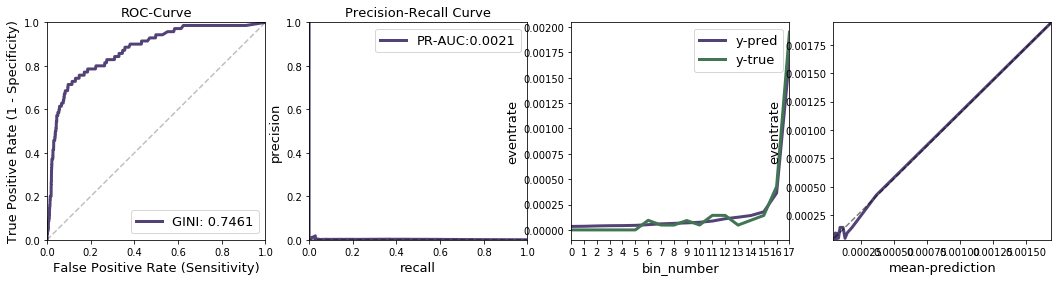

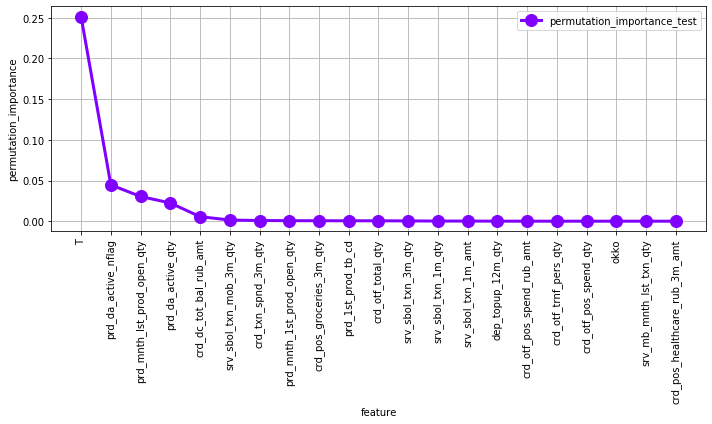

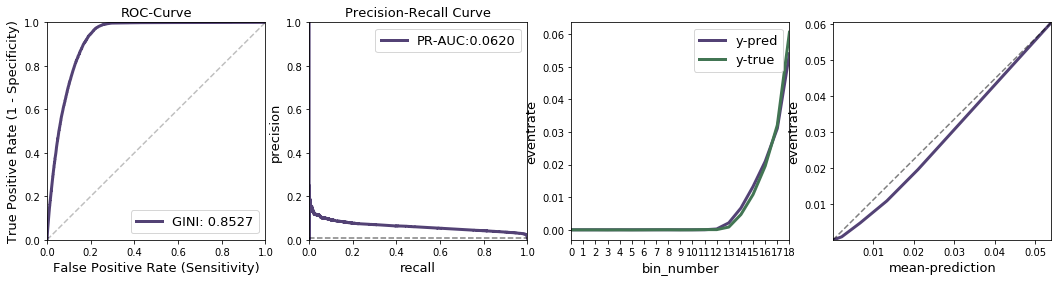

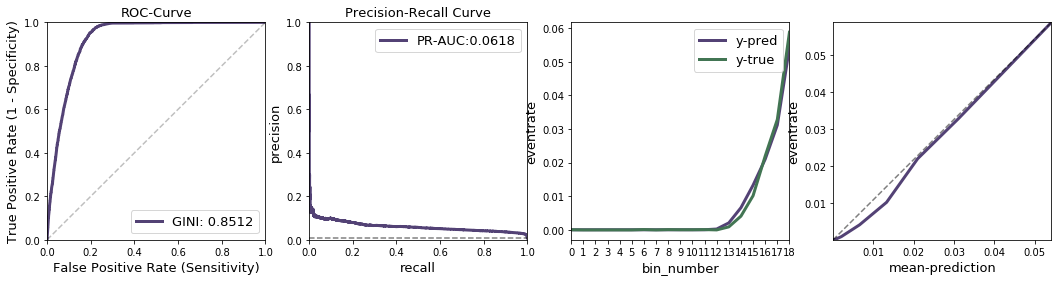

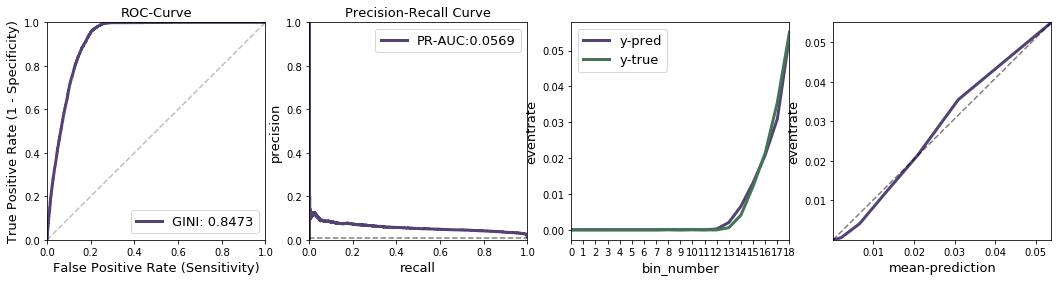

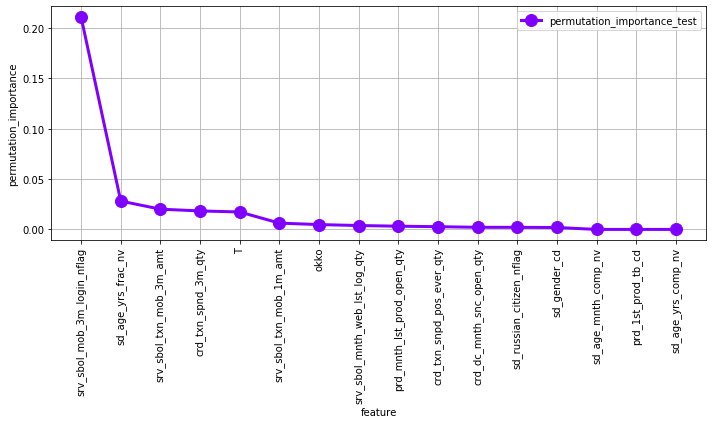

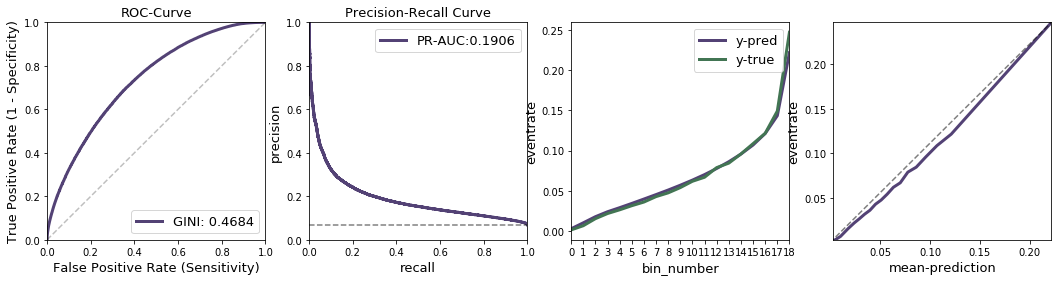

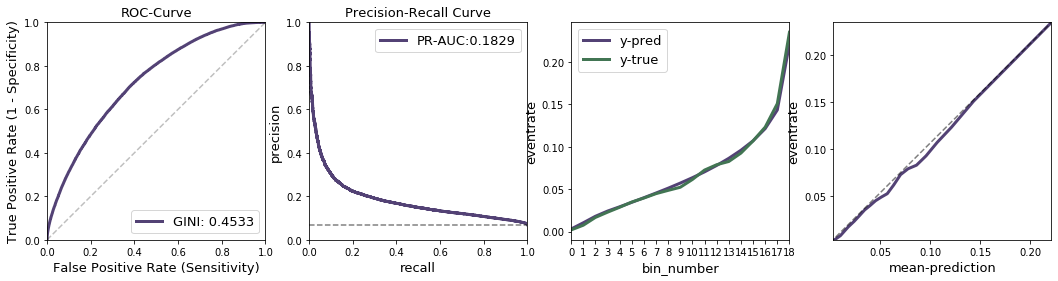

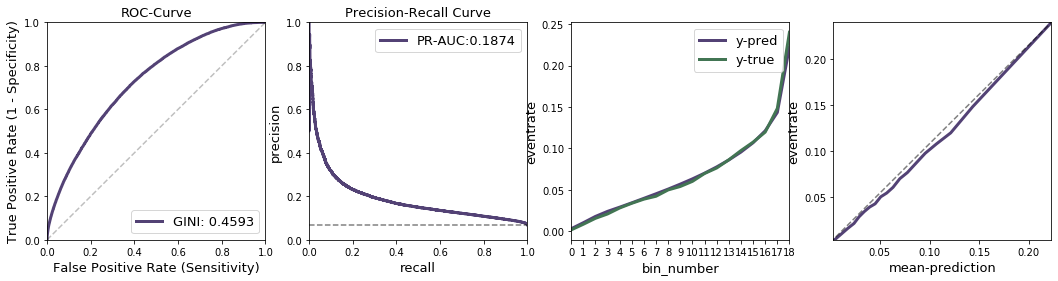

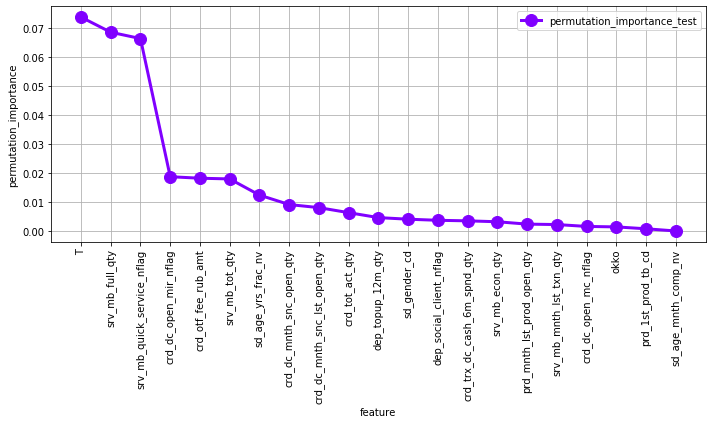

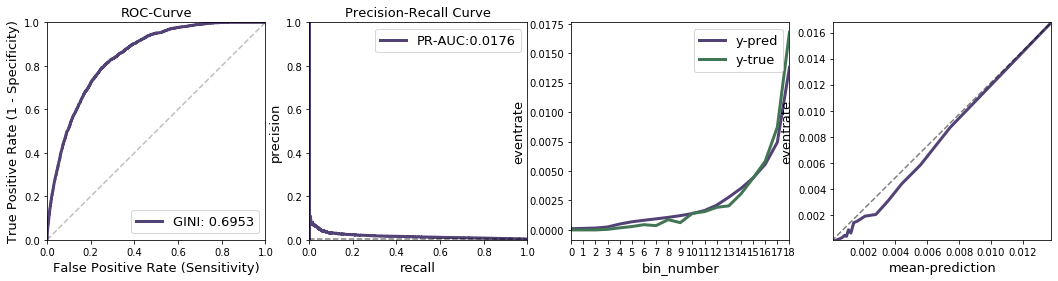

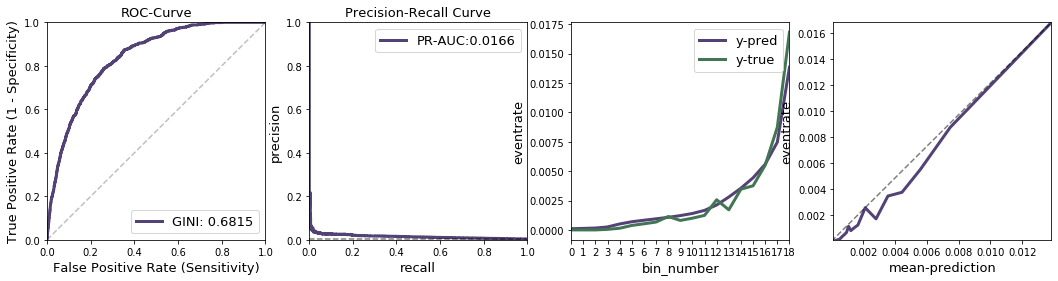

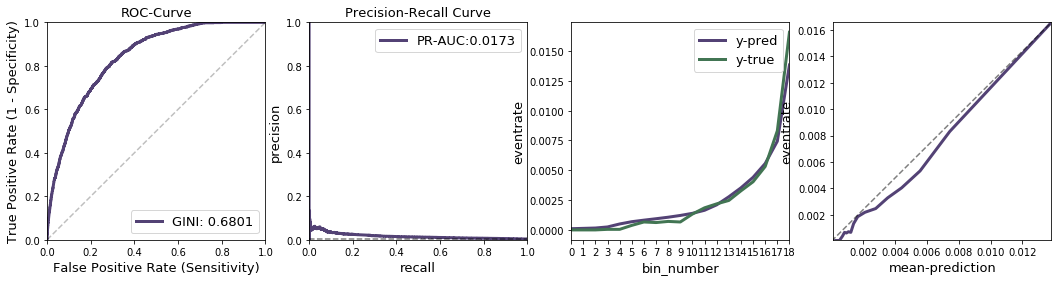

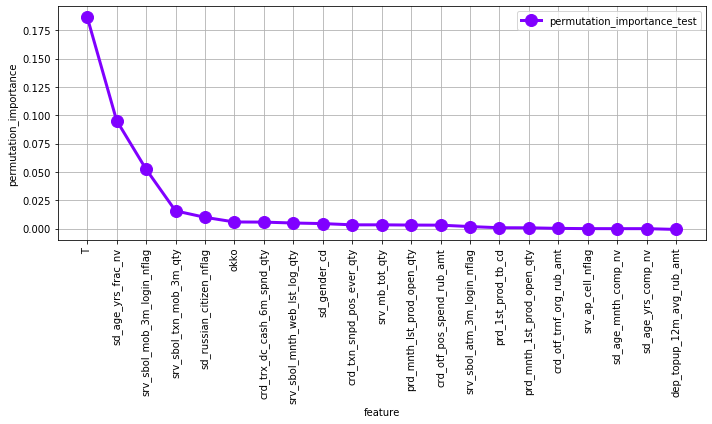

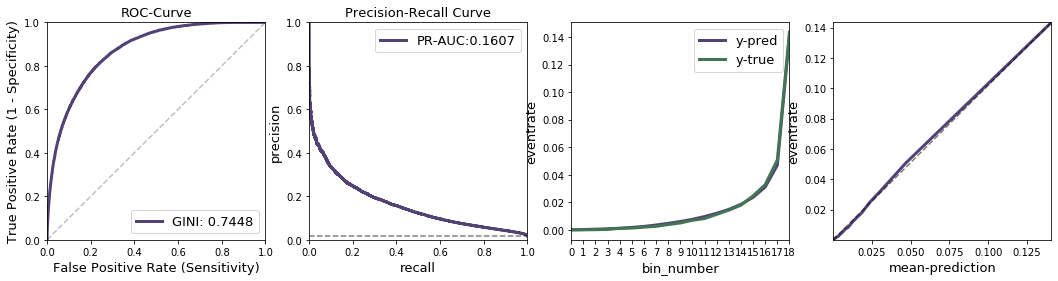

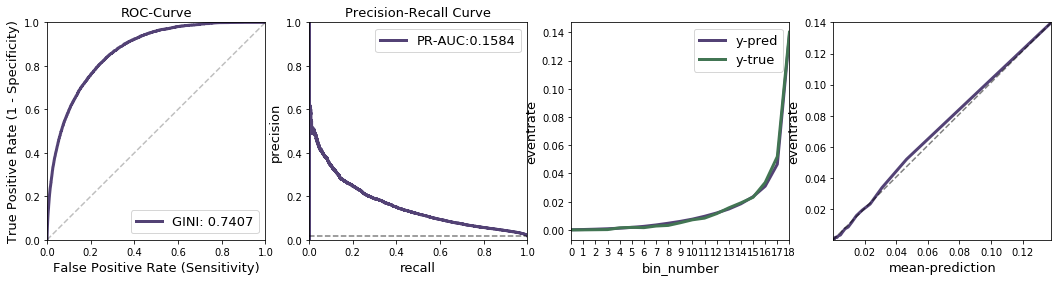

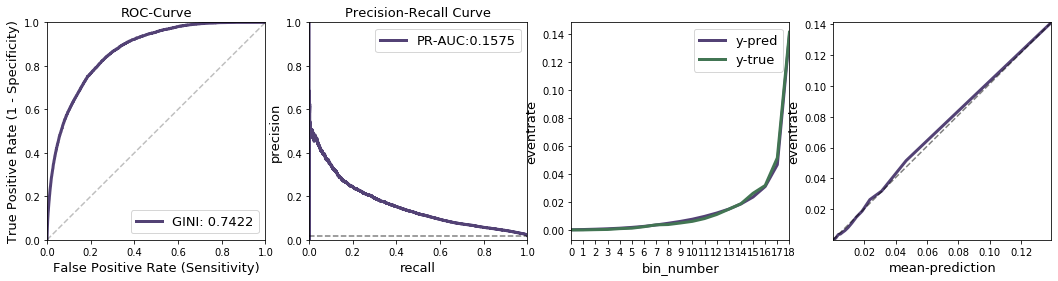

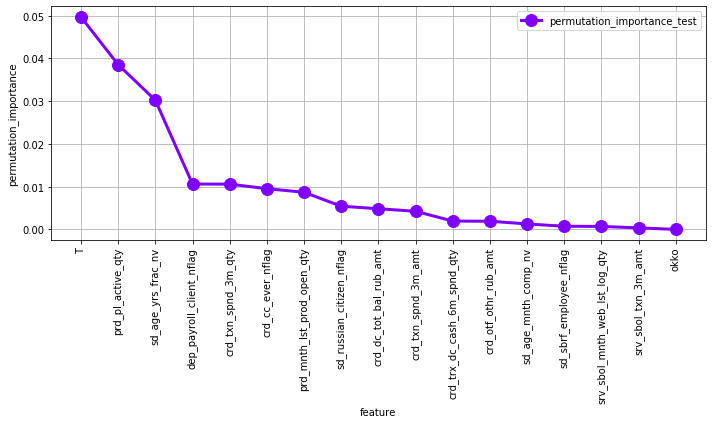

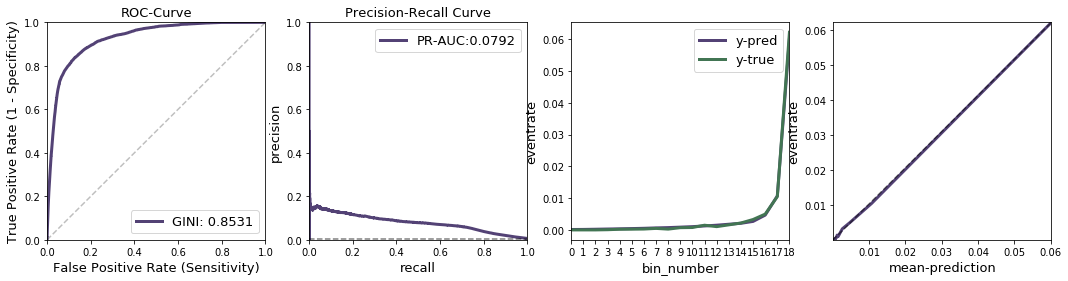

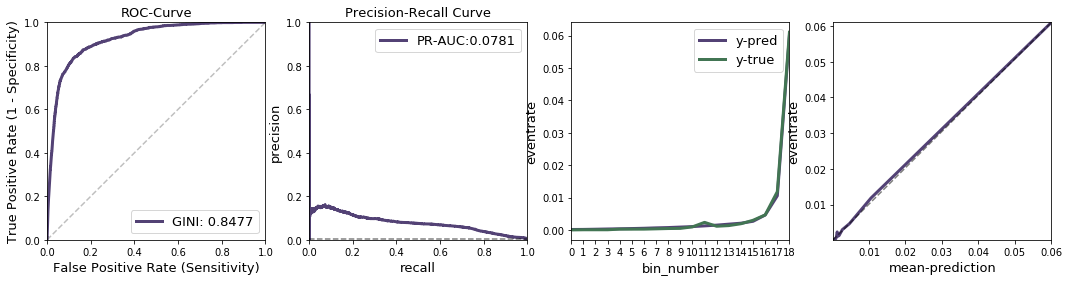

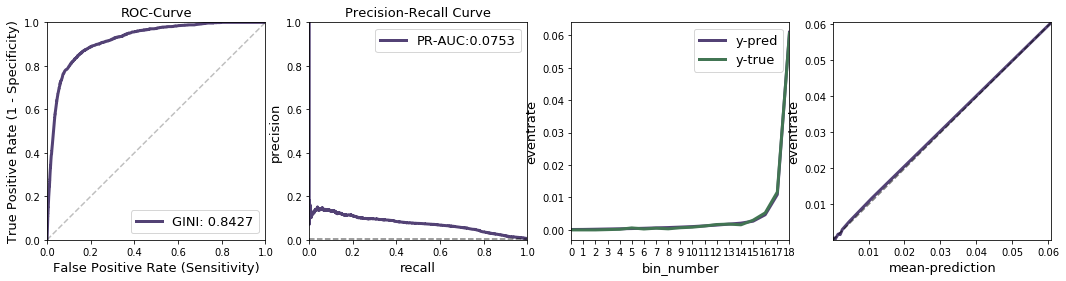

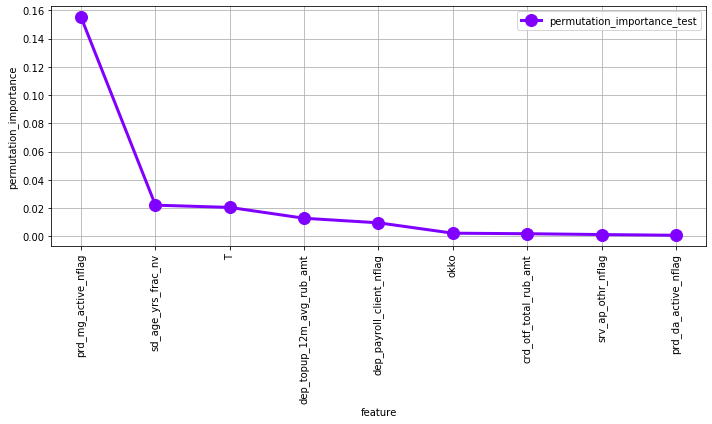

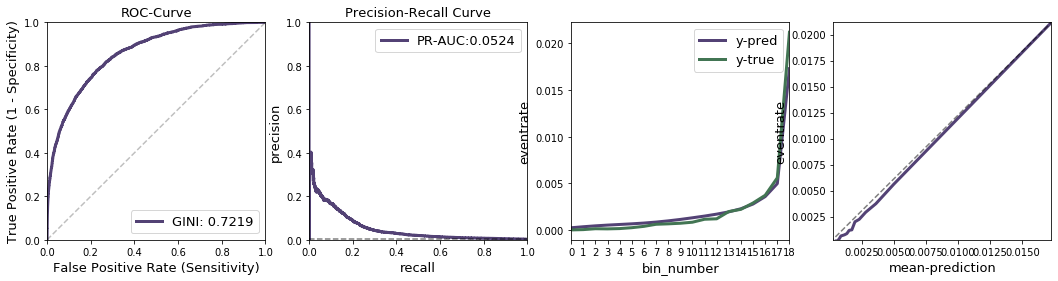

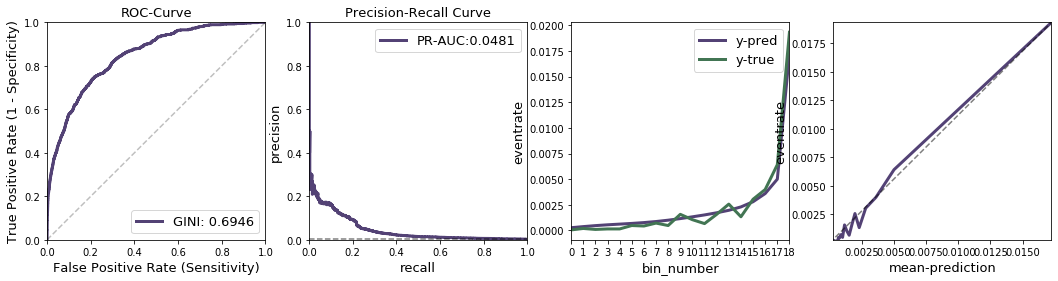

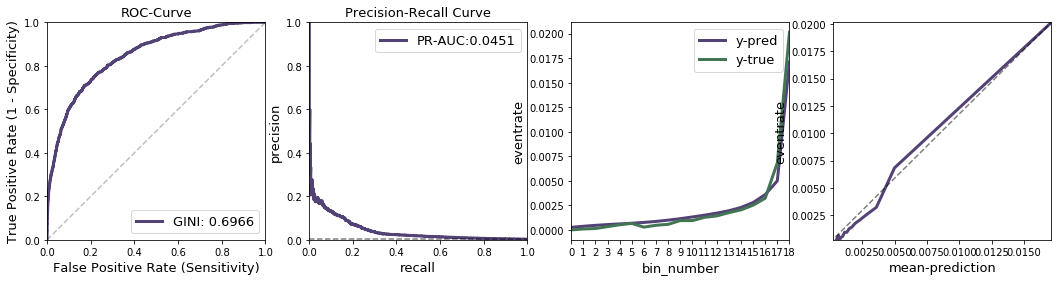

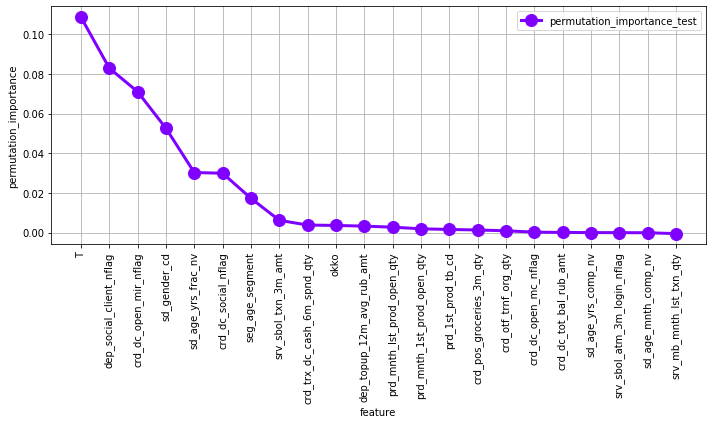

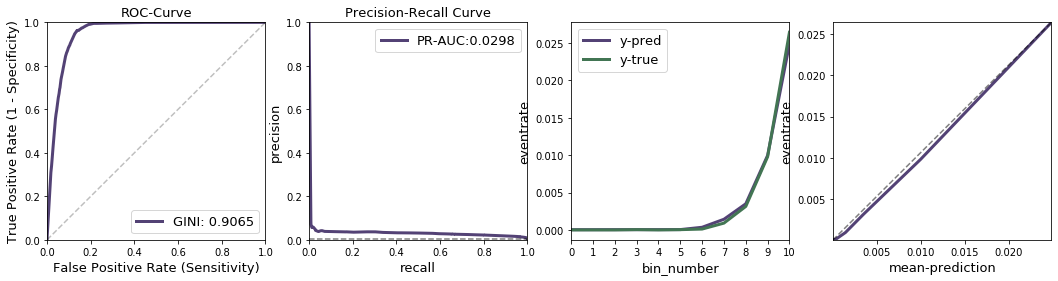

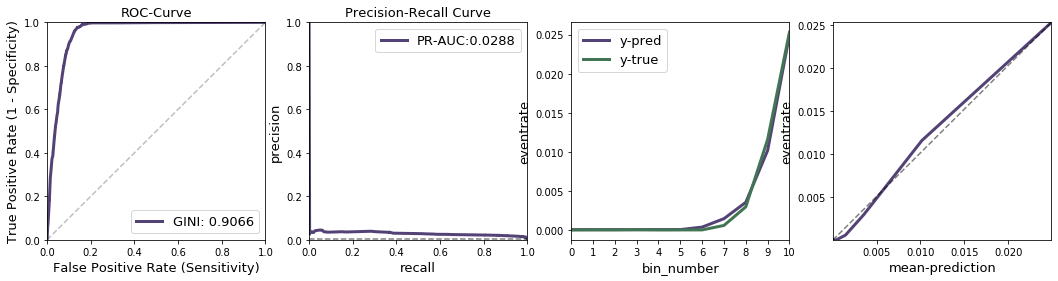

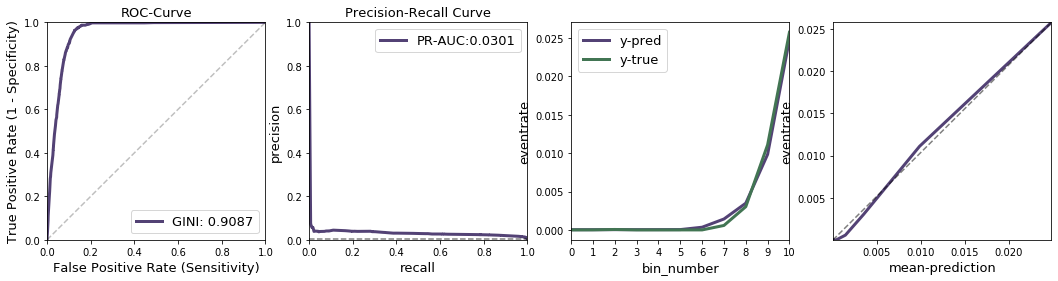

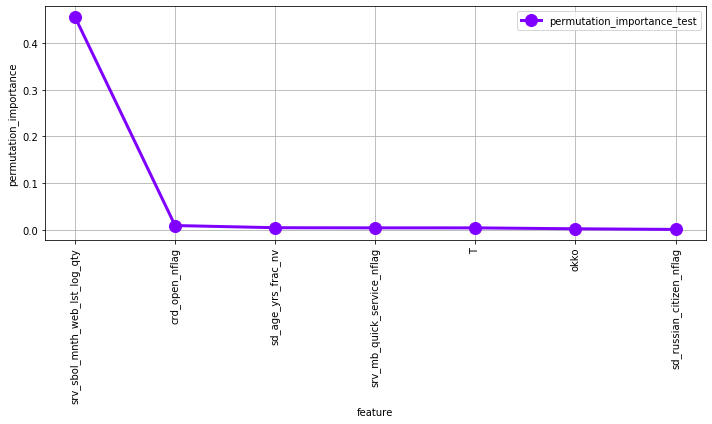

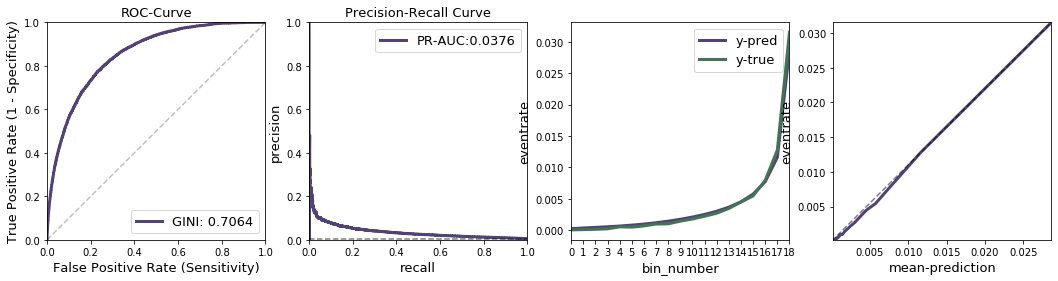

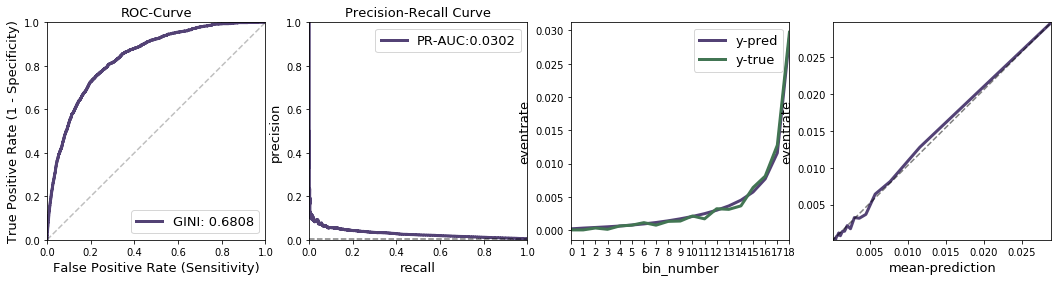

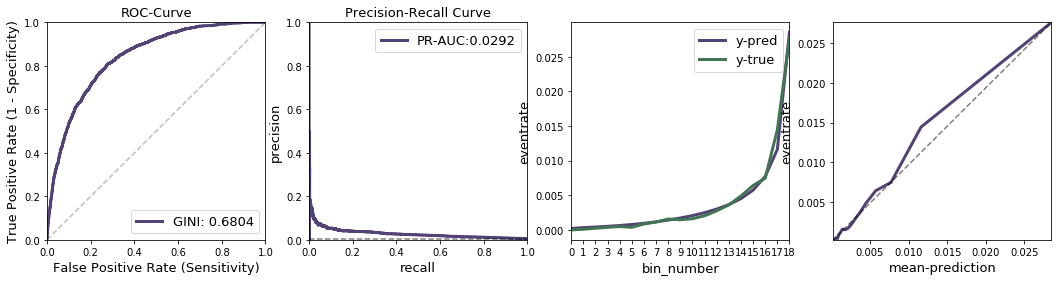

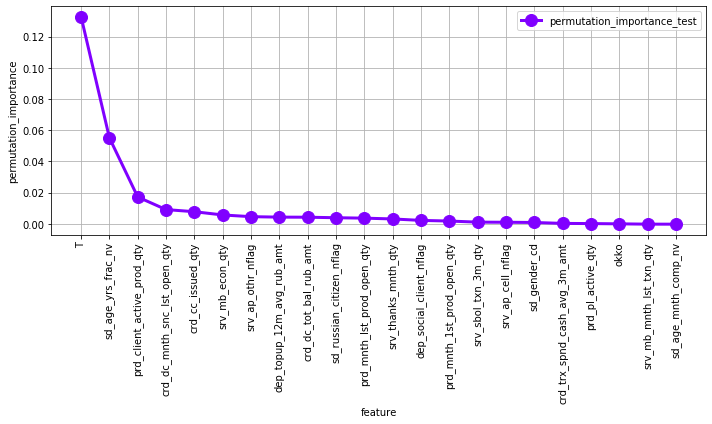

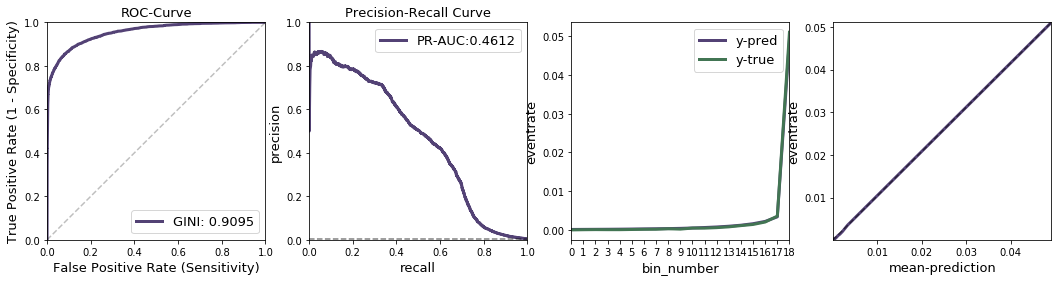

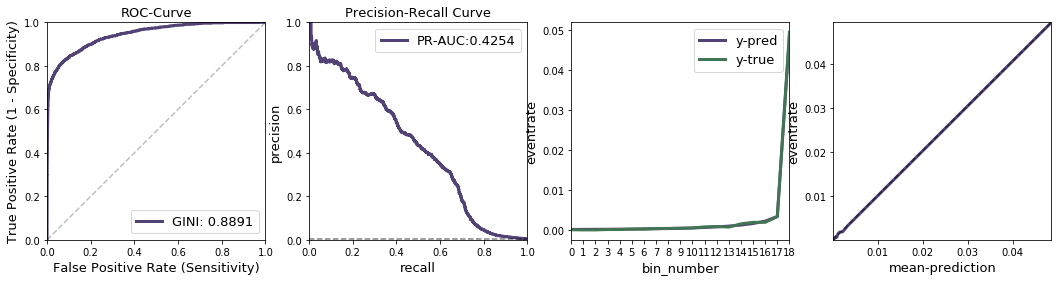

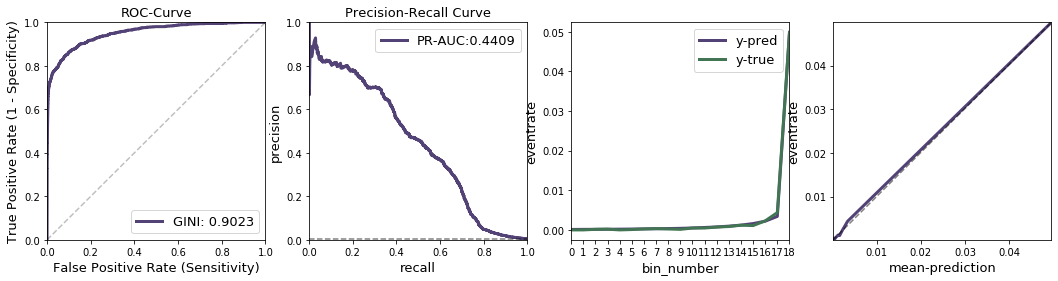

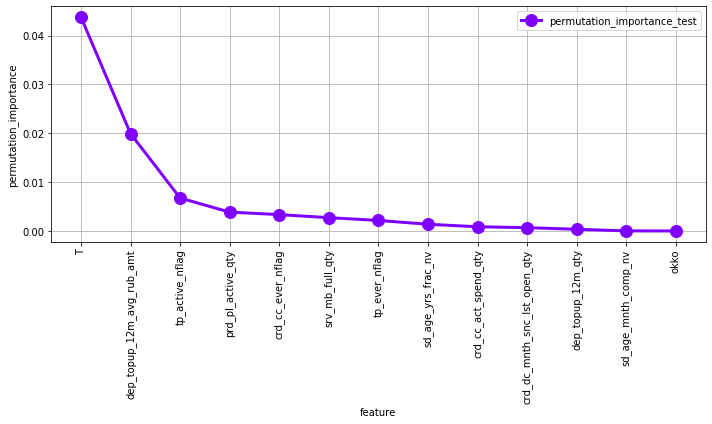

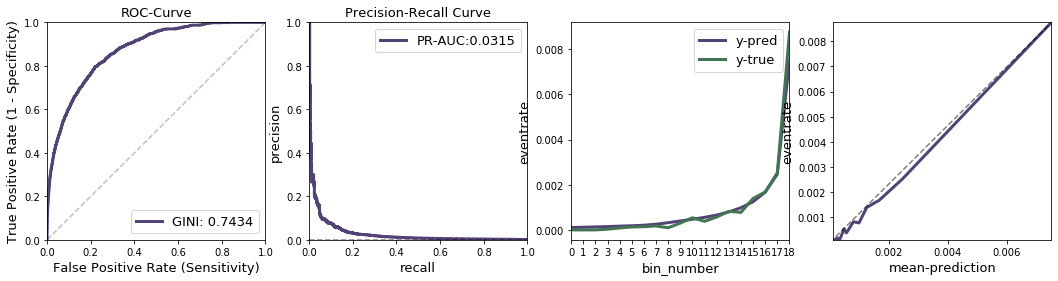

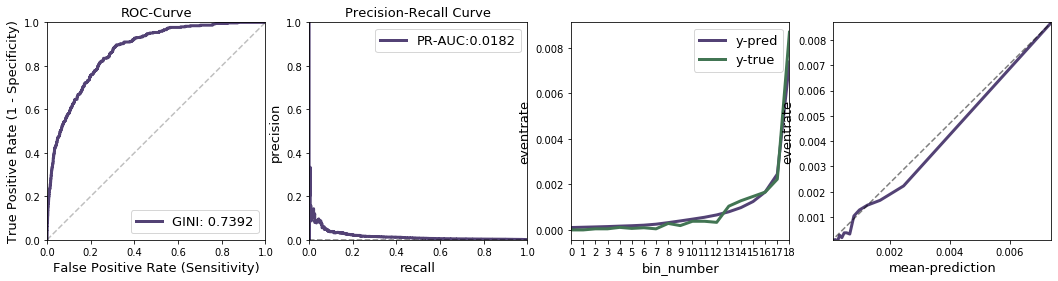

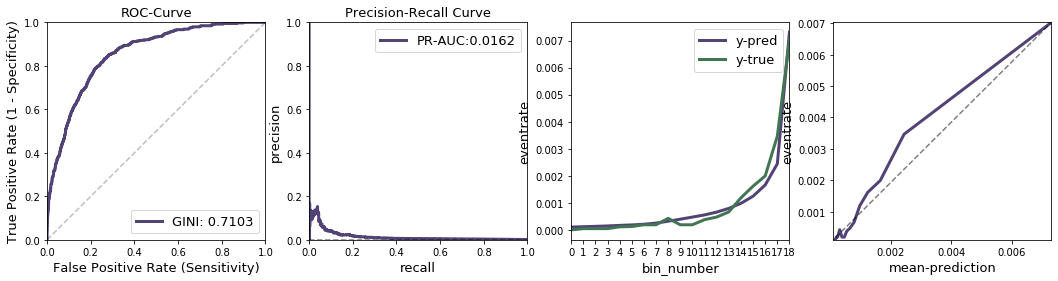

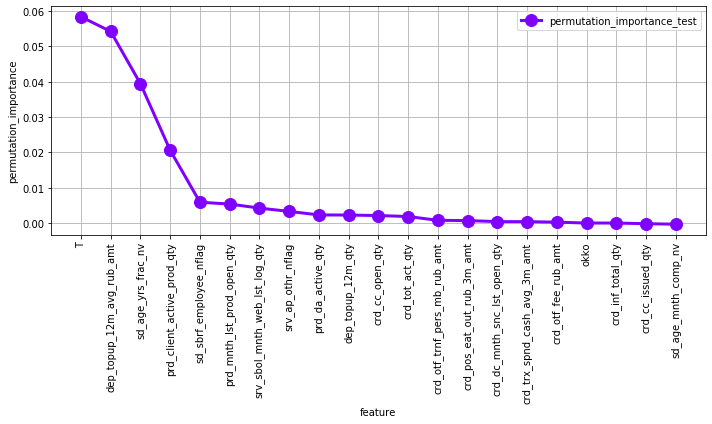

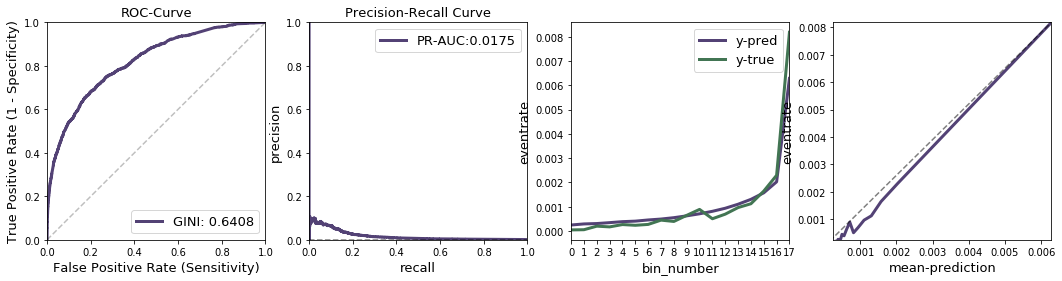

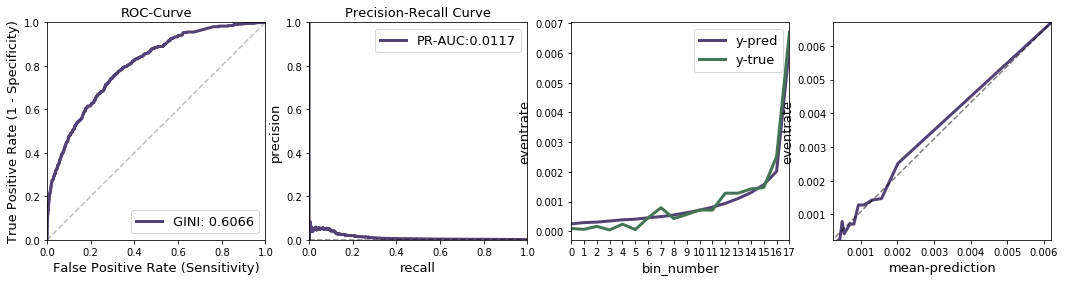

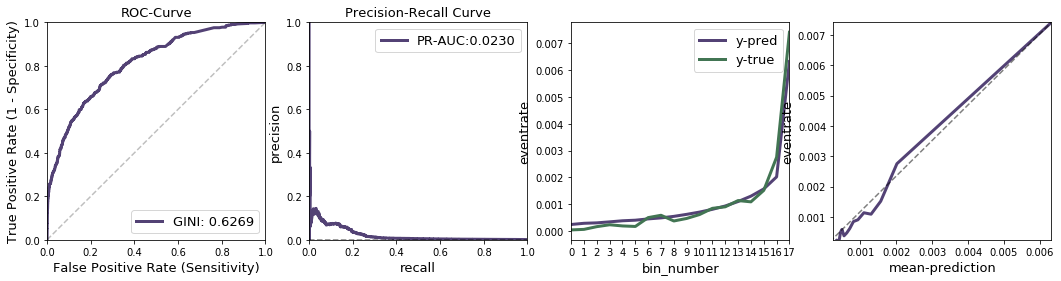

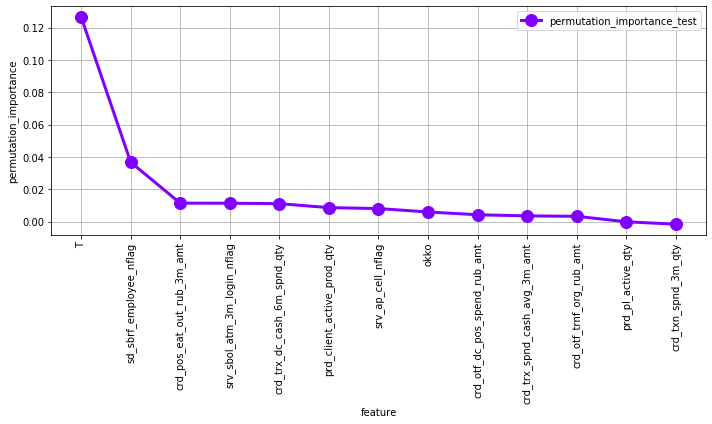

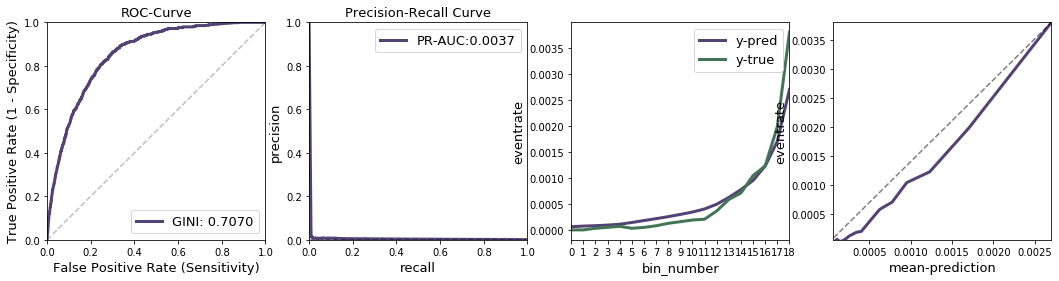

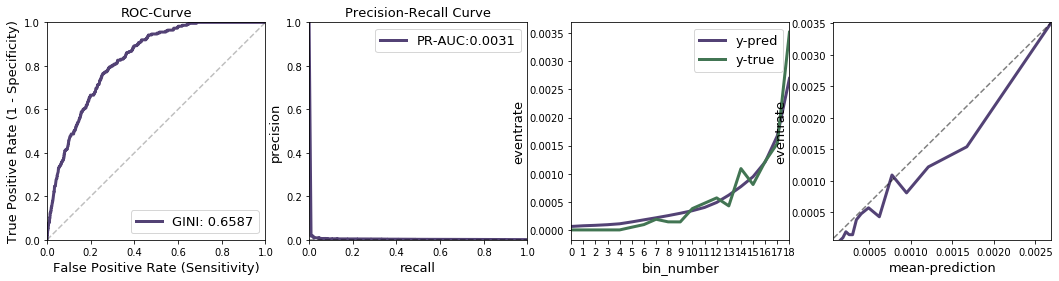

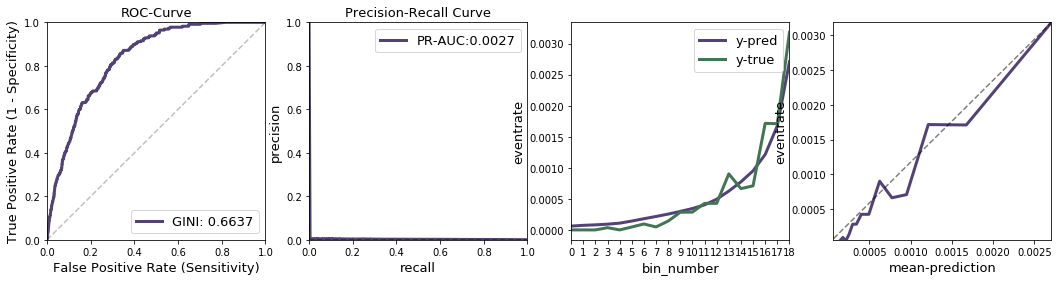

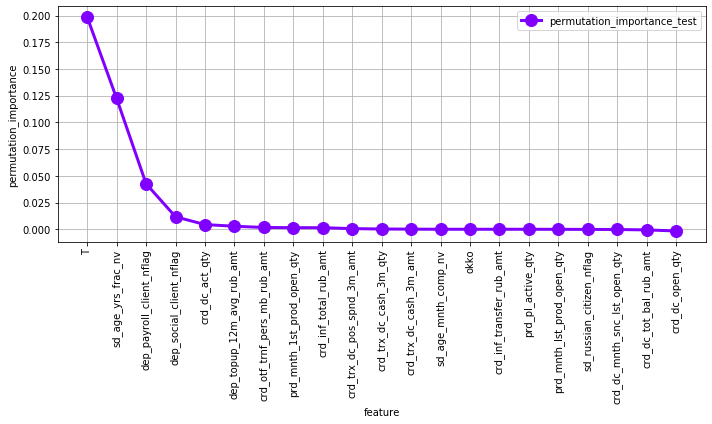

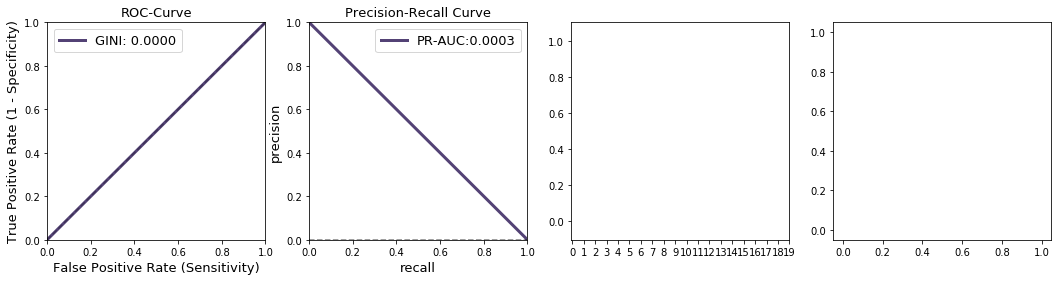

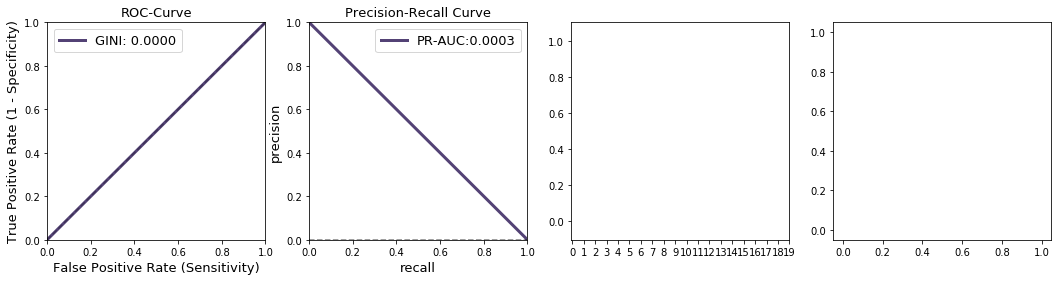

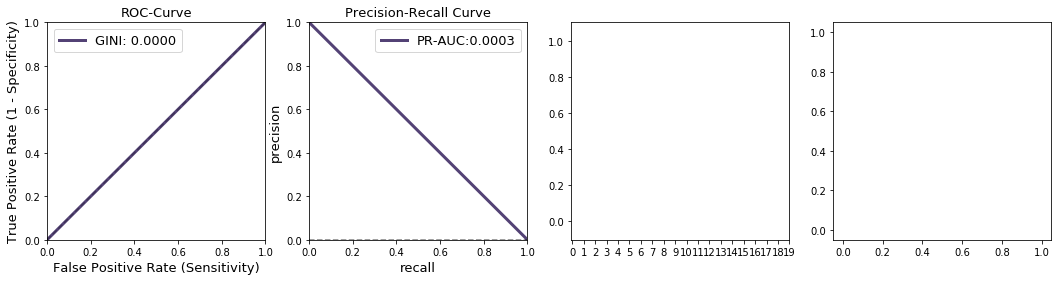

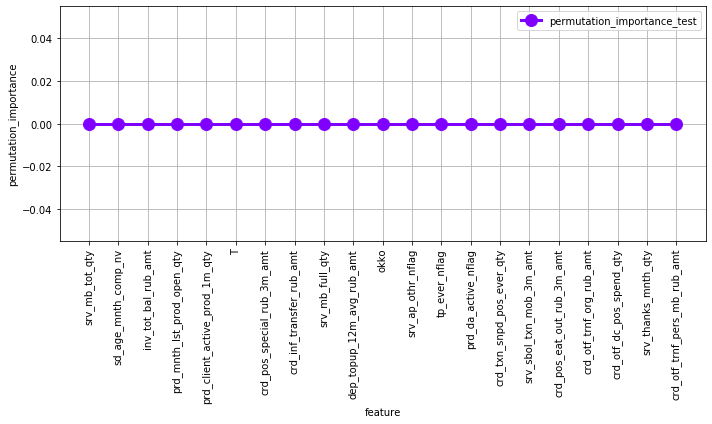

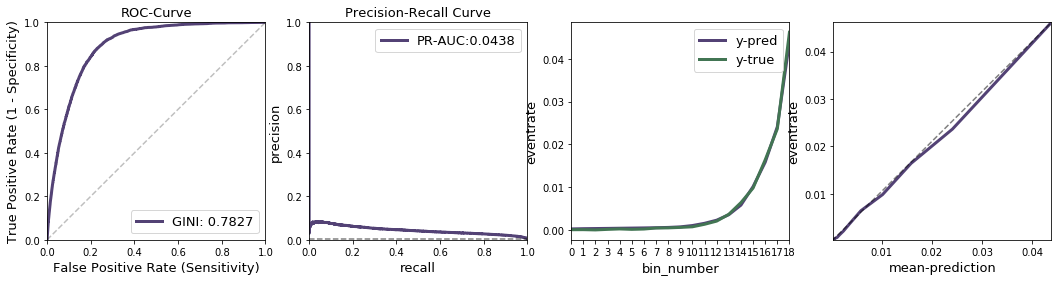

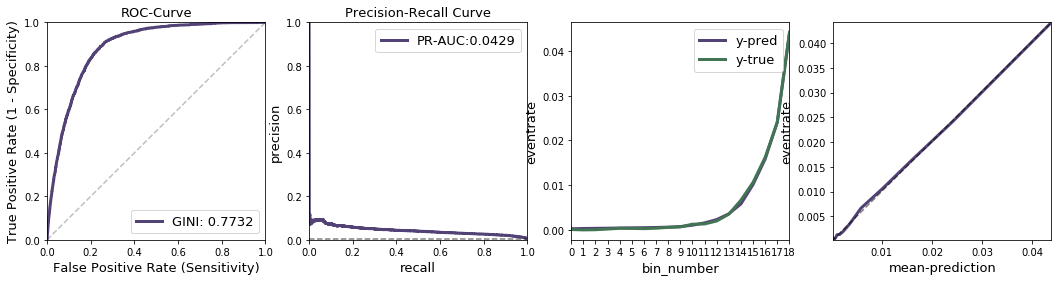

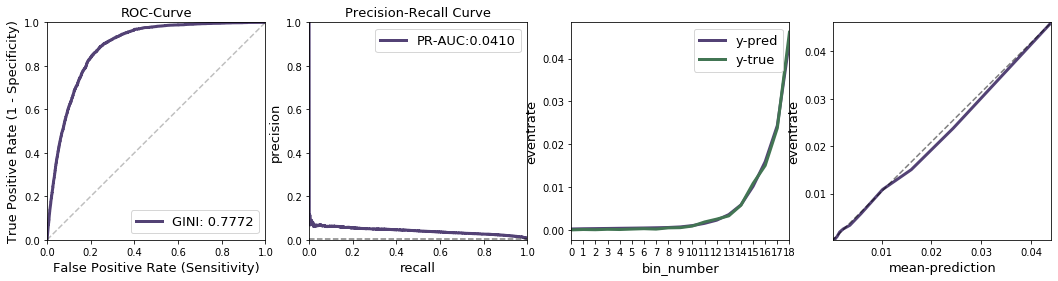

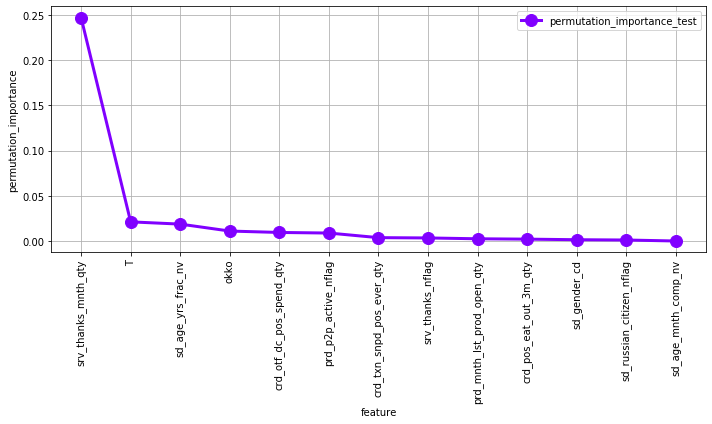

In [17]:
for bp in all_bps:
    
    print(f'fitting {bp}')
    
    np.random.seed(seed)

    config['base_product'] = bp
    config['base_products'] = [bp,]

    f_t = r(f'{config["hue_db_for_traning"]}.train_feature_{bp}_encoded')
    f_o = r(f'{config["hue_db_for_traning"]}.oot_feature_{bp}_encoded')

    f_t_psi = f_t.select(list(set([
        x for x in ['client_dk'] + allowed_features if x in f_t.columns and x not in config['drop_features']
    ]) | {'client_dk', }))
    f_o_psi = f_o.select(list(set([
        x for x in ['client_dk'] + allowed_features if x in f_o.columns and x not in config['drop_features']
    ]) | {'client_dk',}))

    psi_ft_path = os.path.join(art_path, f'psi_ft_list_{bp}.pkl')
    oot_cl_path, oot_psi_cl_path = [
        os.path.join(art_path, f'clients_{bp}_{x}.pkl')
        for x in ('oot', 'oot_psi')
    ]
    psi_score_path =  os.path.join(art_path, f'psi_score_{bp}.pkl')
    
    drop_features_bp_path =  os.path.join(art_path, f'drop_features_{bp}.pkl')
    if not os.path.exists(drop_features_bp_path):
        print('selecting useless features')
        drop_features_bp = []
        for col in set(f_t.columns)&set(allowed_features):
            cnt = f_t[[col]].distinct().count()
            if cnt < 2:
                drop_features_bp.append(col)
        joblib.dump(drop_features_bp, drop_features_bp_path)
    else:
        drop_features_bp = joblib.load(drop_features_bp_path)
    
    f_t = f_t.drop(*drop_features_bp)
    
    if not all([os.path.exists(x) for x in (psi_ft_path, psi_ft_path, psi_ft_path, psi_score_path)]):
        print('selecting psi features')
        pdf_f_t = get_parquets_from_sdf(f_t_psi)
        pdf_f_o = get_parquets_from_sdf(f_o_psi)
        used_features = sorted(list(set(pdf_f_t.columns) - {'client_dk', 'report_dt'}))
        psi_sets, psi_sample = choose_psi_sample({
            'train': (pdf_f_t, pdf_f_t['client_dk']), 
            'OOT': (pdf_f_o, pdf_f_o['client_dk'])
        }, config)
        psi = transformers.PSI(config["psi_threshold"], transformer.cat_features)
        psi_score = psi.fit_transform(pdf_f_t.astype('float32'), pdf_f_o.astype('float32'))
        psi_features = sorted(list(set(psi.used_features + ['client_dk', 'report_dt'])))
        joblib.dump(psi_features, psi_ft_path)
        (pdf_f_t, _), (pdf_f_o, _), (pdf_f_o_psi, _) = psi_sets.values()
        oot_cl, oot_psi_cl = pdf_f_o['client_dk'], pdf_f_o_psi['client_dk']
        joblib.dump(oot_cl, oot_cl_path), joblib.dump(oot_psi_cl, oot_psi_cl_path)
        joblib.dump(psi_score, psi_score_path)
        del _, pdf_f_t, pdf_f_o, pdf_f_o_psi
        gc.collect()    
    else:
        print('loading psi features')
        psi_features, psi_score = [
            joblib.load(x) for x in 
            (psi_ft_path, psi_score_path)
        ]

    print(f'psi_features cnt: {len(psi_features)}')

    for sp in sp_bps:
        
        if f'{bp}_{sp}' in excluded_couples: continue
#         if f'{bp}_{sp}' not in couples_to_refit: continue
        
        print(f'fitting {bp}_{sp}')
        
        model_path = new_model_path
        eval_sets_path = os.path.join(art_path, f'eval_sets_{bp}_{sp}.pkl')

        if os.path.exists(f'{new_model_path}/docs/Validation_report_{bp}_{sp}.xlsx') \
            and os.path.exists(f'{new_model_path}/models/{bp}_{sp}.pkl'):
            print(f'val rep {bp}_{sp} already exists')
            continue
        
        nd_prod = transformer.encoders['Product'].transform([sp])[0]

        t_tr = r(f'{config["hue_db_for_traning"]}.train_target_{bp}_encoded')\
            .filter(f'product = {nd_prod}')
        t_o = r(f'{config["hue_db_for_traning"]}.oot_target_{bp}_encoded')\
            .filter(f'product = {nd_prod}')

        if (bp in ('dc1', 'dc2p') and sp=='dc'):
            t_limit = 1
        elif bp==sp or bp == f'{sp}2':
            t_limit = 1
        else:
            t_limit = 0
        
        print(f't_limit: {t_limit}')
        
        df_tr = f_t.withColumn('y_', F.year('report_dt'))\
            .withColumn('m_', F.month('report_dt'))\
            .drop('report_dt')\
            .join(t_tr.withColumn('y_', F.year('report_dt'))\
                    .withColumn('m_', F.month('report_dt'))\
                    .filter(f'`T` >= {t_limit}'),
                on = ['client_dk', 'y_', 'm_']
            ).drop(*['y_', 'm_'])
        
        df_oot = f_o.withColumn('y_', F.year('report_dt'))\
            .withColumn('m_', F.month('report_dt'))\
            .drop('report_dt')\
            .join(t_o.withColumn('y_', F.year('report_dt'))\
                    .withColumn('m_', F.month('report_dt'))\
                    .filter(f'`T` >= {t_limit}'),
                on = ['client_dk', 'y_', 'm_']
            ).drop(*['y_', 'm_'])

        datasets_length = [df_tr.count(), df_oot.count()]
        if min(datasets_length) < int(5e5):
            print(f'{bp}_{sp} has suspicious low samples: {datasets_length}')
        else:
            print(f'{bp}_{sp} data length: {datasets_length}')
        
        if datasets_length[0] > max_size:
            df_tr_s = get_sample(df_tr, max_size)
            df_oot_s = get_sample(df_oot, max_size)        
        
            positive_cnt = df_tr_s.filter(f'{config["target_name"]} > 0').count()

            def ch_ds_size():
                global positive_cnt
                return (positive_cnt * config['split_params'][1] < 100 \
                    or positive_cnt * config['split_params'][0] < 1000)

            if ch_ds_size():
                positive_cnt = df_tr.filter(f'{config["target_name"]} > 0').count()
                if ch_ds_size():
                    print(f'not enough positive samples in {bp}_{sp}')
                    continue
            else:
                df_tr, df_oot = df_tr_s, df_oot_s

            del df_tr_s, df_oot_s
            gc.collect()
        
        datasets_length = [df_tr.count(), df_oot.count()]
        print(f'{bp}_{sp} data length: {datasets_length}')
        
        eval_sets_paths = {x: f'{eval_sets_path}_{x}.parquet' for x in ('train', 'test', 'valid', 'OOT')}
        
        if not all([os.path.exists(x) for x in eval_sets_paths.values()]):
            np.random.seed(seed)
            print(f'preparing eval_sets for {bp}_{sp}')
            pdf_tr = get_parquets_from_sdf(
                df_tr.select(list(set([*[x for x in psi_features if x in df_tr.columns ], *t_tr.columns])))
            )
            gc.collect()
            splitter = DataSplitter(
                config["split_params"], 'T'
            )
            eval_sets = splitter.transform(
                pdf_tr.drop(config['target_name'], 1),
                pdf_tr[config['target_name']]
            )
            del pdf_tr
            gc.collect()
            pdf_o = get_parquets_from_sdf(
                df_oot.select(list(set([*[x for x in psi_features if x in df_oot.columns], *t_o.columns])))
            )
            eval_sets['OOT'] = (
                pdf_o.drop(config['target_name'], 1),
                pdf_o[config['target_name']]
            )
            del pdf_o
            gc.collect()
            save_eval_sets_to_prq(*eval_sets_paths.items())
        else:
            print('loading eval sets..')
            eval_sets = {x: read_eval_sets(y) for x, y in eval_sets_paths.items()}
            gc.collect()
        
        for key in eval_sets.keys():
            cur_ctg_features = list(
                (set(config['categorical_features_full'])|set(['T',bp,config['target_name'],'client_dk']))\
                & set(eval_sets[key][0].columns)
            )
            tmp_df = eval_sets[key][0].copy()
            for col in tqdm(tmp_df.columns):
                if col in cur_ctg_features:
                    tmp_df[col] = tmp_df[col].astype('int64')
                else:
                    tmp_df[col] = tmp_df[col].astype('float32', errors = 'ignore')
                gc.collect()
            eval_sets[key] = tmp_df, eval_sets[key][1].astype('int64')
            del tmp_df
            gc.collect()
        
        np.random.seed(seed)

        models = {}
        used_features = list(
            (set(eval_sets['train'][0].columns.tolist()) & set(psi_features))-set(config['drop_features'])
        )

        model_name = f'{bp}_{sp}'

        psi_params.update({
            "categorical_features": \
                list(set(config['categorical_features_full'])&set(used_features))
        })

        psi_model = classifiers.LGBMClassifierModel(
            psi_params, used_features, **optional_params
        )
        psi_model.fit(*eval_sets["train"], *eval_sets["valid"])
        psi_model.evaluate_model(**eval_sets)
        
        try:
            perm_features_df = psi_model.feature_importance(*eval_sets["valid"])
        except ValueError:
            continue
        perm_features = select_subset_features(
            perm_features_df, config["permutation_threshold"]
        )

        if len(perm_features) > 20:
            perm_features = select_subset_features(
                perm_features_df, top_k = 19
            )

        perm_features = list(set(perm_features + ['T', bp]))
        
        config['categorical_features'] = list(
            set(config['categorical_features_full'])&set(eval_sets['train'][0].columns)
        )
        
        if eval_sets['train'][1].shape[0] > int(5e5):
            xgb_params.update({
                'categorical_features': [x for x in perm_features if x in config['categorical_features_full']]
            })
            model = classifiers.XGBClassifierModel(
                xgb_params, perm_features, **optional_params
            )
            
        else:
            model = classifiers.CBClassifierModel(
                cb_params, perm_features, **optional_params
            )
        
        model.fit(*eval_sets["train"], *eval_sets["valid"])
        model.evaluate_model(**eval_sets)
        metrics_cur = get_metrics(eval_sets, model)
        
        n_trgs_train = eval_sets['train'][1].sum()
        metrics_new = metrics_new.append(pd.DataFrame(dict(zip(
            metrics_new.columns.tolist(),
            [[x] for x in [f'{bp}_{sp}', n_trgs_train] + metrics_cur]
        ))), ignore_index=True)

        display(HTML(metrics_new[-1:].to_html()))

        metrics_new.to_excel(metrics_new_path, index = False)

        models[model_name] = model

        saver = INFOSaver
        saver = saver(models, config)
        saver.dir_ = new_model_path
        saver.save()

        config['categorical_features'] = list(
            set(config['categorical_features_full'])&set(model.used_features)
        )

        del eval_sets['OOT']
        gc.collect()

        reporter = ValidationReporter(
            models=models, names=model_name, config=config, 
            current_path=nd_path, uplift_builder = False
        )
        reporter.transform(**eval_sets)

        for i in ('eval_sets', 'model', 'psi_model'):
            if '{i}' in globals().keys(): exec(f'del {i}')
        gc.collect()
        spark.catalog.clearCache()

In [18]:
gc.collect()

512055

In [27]:
%%time

nd_products = ['okko',]

nd_path_d = os.path.join(nd_path, 'docs')

models_stat = pd.DataFrame(columns = [
    'model', 'train_targets', 'e_rate_train', 'e_rate_oot',
    'gini_train', 'gini_valid', 'gini_test', 'gini_oot', 'gini_oot_psi',
    't_min', 't_max', 'bp_feature_importance', 'bp_feature_importance_place',
    'used_features_qty', 'used_features' 
])

pr_models = []

###############################
for file in tqdm(os.listdir(nd_path_d)):#bps:
    
    if not any([f'rt_{x}' in file for x in nd_products]): continue
#     if "_".join(file[:-5].split('_')[-2:]) not in ('dlcc_ap',): continue
    
    val_rep_name = os.path.join(nd_path_d, file)
    bp, sp = file.split('.')[0].split('_')[-2:]    
    wb = load_workbook(val_rep_name)
    ws = wb['Model Summary']
    
    bp_ft_imp, bp_imp_pl = np.nan, np.nan
    used_features = []
    c_i, stop_i = 2, 0
    
    e_rate_train, e_rate_oot = [ws[f'{x}12'].value for x in list('BE')]

    gini_train, gini_valid, gini_test, gini_oot, gini_oot_psi = \
        [ws[f'{x}13'].value for x in list('BCDEF')]

    ws = wb['Data Statistics']
    train_targets = ws['C2'].value

    ws = wb['perm_importance']
    
    f_data = pd.read_excel(val_rep_name, sheet_name='PSI detailed', usecols='A,E,F')
    
    t_min, t_max = f_data[f_data['feature']=='T'].agg({
       'min_value': 'min', 'max_value': 'max'	
    }).values
    
    while ws[f'A{c_i}'].value != 'factors_relevancy' and stop_i < 1000:
        f_name = ws[f'A{c_i}'].value
        used_features.append(f_name)
        if bp == f_name:
            bp_ft_imp = ws[f'B{c_i}'].value
            bp_imp_pl = stop_i + 1 if bp_ft_imp > 0 else np.nan
        c_i += 1
        stop_i += 1
    
    ft_qty = len(used_features) 
    
    fb_ft = [x for x in used_features if x in config['drop_features']]
    if any(fb_ft):
        print(f'forbiden features in {bp}_{sp}')
        pr_models.append((f'{bp}_{sp}', fb_ft))

    models_stat.loc[len(models_stat)] = [
        f'{bp}_{sp}', train_targets, e_rate_train, e_rate_oot,
        gini_train, gini_valid, gini_test, gini_oot, gini_oot_psi,
        t_min, t_max, bp_ft_imp, bp_imp_pl, ft_qty,','.join(used_features)
    ]
    gc.collect()


100%|██████████| 208/208 [00:08<00:00, 25.07it/s]

CPU times: user 8.08 s, sys: 281 ms, total: 8.36 s
Wall time: 8.3 s


In [28]:
models_stat

,model,train_targets,e_rate_train,e_rate_oot,gini_train,gini_valid,gini_test,gini_oot,gini_oot_psi,t_min,t_max,bp_feature_importance,bp_feature_importance_place,used_features_qty,used_features
0,okko_t2f,310,0.000258,None,0,0,0,None,None,0,3,0,NaN,21,"srv_mb_tot_qty,sd_age_mnth_comp_nv,inv_tot_bal..."
1,okko_dc,37399,0.031166,None,0.525125,0.510282,0.506604,None,None,0,3,0.00141166,17.0,22,"T,crd_dc_open_mir_nflag,sd_age_yrs_frac_nv,sd_..."
2,okko_h,3066,0.002555,None,0.686992,0.660846,0.650041,None,None,0,3,0.00582511,4.0,16,"sd_age_yrs_frac_nv,T,dep_payroll_client_nflag,..."
3,okko_sbl,2554,0.002128,None,0.906495,0.906573,0.908707,None,None,0,3,0.00219199,5.0,7,"srv_sbol_mnth_web_lst_log_qty,crd_open_nflag,s..."
4,okko_d33,4690,0.003908,None,0.813738,0.806298,0.799592,None,None,0,3,0.00248063,6.0,17,"sd_age_yrs_frac_nv,prd_mg_active_nflag,T,dep_p..."
5,okko_ap,125723,0.104769,None,0.724663,0.726361,0.723246,None,None,0,3,0.000479414,12.0,13,"crd_otf_trnf_org_rub_amt,srv_ap_utl_nflag,T,de..."
6,okko_dnpr,5441,0.004534,None,0.720568,0.682944,0.69868,None,None,0,3,-4.3141e-05,NaN,18,"T,prd_pl_active_qty,sd_age_yrs_frac_nv,crd_cc_..."
7,okko_sh,1162,0.000968,None,0.743368,0.739153,0.710304,None,None,0,3,0,NaN,21,"T,dep_topup_12m_avg_rub_amt,sd_age_yrs_frac_nv..."
8,okko_sm,1216,0.001013,None,0.640835,0.606605,0.626937,None,None,0,3,0.00590352,7.0,13,"T,sd_sbrf_employee_nflag,crd_pos_eat_out_rub_3..."
9,okko_th,7131,0.005942,None,0.78266,0.773163,0.777177,None,None,0,3,0.0111379,3.0,13,"srv_thanks_mnth_qty,T,sd_age_yrs_frac_nv,okko,..."


In [31]:
models_stat[models_stat['used_features'].str.contains('prd_client_active_prod,')]

,model,train_targets,e_rate_train,e_rate_oot,gini_train,gini_valid,gini_test,gini_oot,gini_oot_psi,t_min,t_max,bp_feature_importance,bp_feature_importance_place,used_features_qty,used_features


In [29]:
models_stat.to_excel(os.path.join(nd_path, 'metrics_okko.xlsx'), index=False)

In [68]:
import os
from tqdm import tqdm

put_expr = \
    'hdfs dfs -put -f /opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/{}/'\
    '{}*{}{} hdfs://clsklsbx/user/team/team_cvm_rb/CLTV/24_base_models/{}'
for bp in tqdm(all_bps):
    bash_expr = ''
    folder, file_type = 'data', 'eval'
    for sets_type in ('*train*', '*test*', '*valid*'):
        bash_expr += put_expr.format(folder, file_type, bp, sets_type, folder) + ' && '
    file_type = 'drop_fea'
    bash_expr += put_expr.format(folder, file_type, bp, '*', folder) + ' && '
    folder, file_type = 'models', '.pkl'
    bash_expr += put_expr.format(folder, bp, file_type, '*', folder) + ' && '
    folder, file_type = 'docs', f'Validation_report_{bp}'
    bash_expr += put_expr.format(folder, file_type, '', '', folder) + ' && '
    bash_expr += f'echo "{bp} done"'
    
    os.system(bash_expr)
# bash_expr += 'echo "completely done"'


100%|██████████| 25/25 [03:03<00:00,  7.33s/it]


In [97]:
p1 = '/opt/workspace/yakovlev-ra_ca-sbrf-ru/runs/docs'
p2 = '/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/docs'
c = 0
for f in os.listdir(p1):
    if not os.path.exists(os.path.join(p2, f)):
        shutil.copyfile(
            os.path.join(p1, f), os.path.join(p2, f)
        )
        c+=1
print(c)

15


In [146]:
pr_models

[('sc_th', ['crd_otf_total_qty_6a']),
 ('sc_pl', ['crd_otf_total_qty_12a']),
 ('sc_st', ['crd_otf_total_qty_12a']),
 ('dc_sc', ['crd_inf_total_qty_12a']),
 ('dlcc_ap', ['crd_otf_total_qty_12a']),
 ('dc_plg', ['crd_inf_total_qty_12a']),
 ('sc_h', ['crd_inf_total_qty_12a']),
 ('dc_mb', ['crd_inf_total_qty_12a']),
 ('sc_dnpr', ['crd_otf_total_qty_12a']),
 ('sc_mb', ['crd_inf_total_qty_12a']),
 ('dc_sc', ['crd_inf_total_qty_12a']),
 ('dlcc_ap', ['crd_otf_total_qty_12a']),
 ('dc_plg', ['crd_inf_total_qty_12a']),
 ('dc_mb', ['crd_inf_total_qty_12a'])]

In [178]:
models_stat[models_stat['model'].isin([x[0] for x in pr_models])]

,model,train_targets,e_rate_train,e_rate_oot,gini_train,gini_valid,gini_test,gini_oot,gini_oot_psi,t_min,t_max,used_features


In [195]:
mld = [x[:-4] for x in os.listdir('../cltv_score_ld/models')]

In [196]:
len(mld)

674

In [197]:
[x for x in mld if x not in models_stat['model'].values]

[]

In [187]:
models_stat[
    (~models_stat['model'].isin(mld))
]

,model,train_targets,e_rate_train,e_rate_oot,gini_train,gini_valid,gini_test,gini_oot,gini_oot_psi,t_min,t_max,used_features,bp,sp,gini_dif


In [184]:
models_stat.shape

(674, 15)

In [168]:
models_stat[models_stat['model']=='sc_dnpr']

,model,train_targets,e_rate_train,e_rate_oot,gini_train,gini_valid,gini_test,gini_oot,gini_oot_psi,t_min,t_max,used_features


In [161]:
joblib.load('/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/models/sm_sm.pkl').used_features

['srv_sbol_web_3m_login_nflag',
 'sd_sbrf_employee_nflag',
 'sd_age_mnth_comp_nv',
 'prd_client_active_prod_qty',
 'crd_lst_agrmnt_tb_cd',
 'crd_pos_telecom_rub_3m_amt',
 'T',
 'srv_sbol_atm_3m_login_nflag',
 'sm']

In [183]:
models_stat.to_excel(os.path.join('/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021', 'metrics_vl_all.xlsx'), index=False)

In [54]:
all_fts = []
models_path = os.path.join(nd_path, 'models') 
for file in os.listdir(models_path):
    all_fts.extend([
        x for x in joblib.load(os.path.join(models_path, file)).used_features
        if x not in [*all_fts, 'T', *all_bps, *[x+'2' for x in all_bps]]
    ])

In [55]:
len(all_fts), len(allowed_features)

(239, 253)

In [179]:
models_stat[['bp', 'sp']] = models_stat['model'].str.split('_', 2, expand=True)

In [180]:
models_stat['gini_dif'] = (models_stat['gini_test'] - models_stat['gini_train']).abs()

In [181]:
problem_models = models_stat[
    (models_stat['bp'].isin(('dc1', 'dc2p')) & models_stat['sp'].isin(('dc',)) & models_stat['t_min'].isin((0,)) )
    | ((models_stat['bp'] == models_stat['sp']) & models_stat['t_min'].isin((0,)))
    | ((models_stat['bp'] == models_stat['sp']+'2') & models_stat['t_min'].isin((0,)))
    | ((models_stat['bp'].str.startswith('EL') & models_stat['sp'].isin(('pl',)))& models_stat['t_min'].isin((0,)))
    | (models_stat[[ 'gini_train', 'gini_valid', 'gini_test']].min(axis=1) < 0.3)
    | (models_stat['gini_dif'] > 0.05)
].copy()

# problem_models = problem_models[problem_models['t_min']==0]

In [145]:
models_stat[models_stat['model']=='dlcc_ap']

,model,train_targets,e_rate_train,e_rate_oot,gini_train,gini_valid,gini_test,gini_oot,gini_oot_psi,t_min,t_max,used_features
686,dlcc_ap,39023,0.041621,None,0.574026,0.569156,0.57867,None,None,0,4,"dlcc,T,sd_age_yrs_frac_nv,prd_client_active_pr..."


In [182]:
problem_models.sort_values('gini_dif', ascending=False)

,model,train_targets,e_rate_train,e_rate_oot,gini_train,gini_valid,gini_test,gini_oot,gini_oot_psi,t_min,t_max,used_features,bp,sp,gini_dif
478,dlcc_dlcc,1216,0.001621,None,0.592315,0.505787,0.522232,None,None,1,4,"dlcc,T,sd_age_yrs_frac_nv,prd_pl_active_nflag,...",dlcc,dlcc,0.070083
440,EL18_sbl,1195,0.004299,None,0.601740,0.562871,0.536252,None,None,0,12,"T,srv_mb_tot_qty,sd_age_yrs_frac_nv,srv_sbol_t...",EL18,sbl,0.065488
574,EL12_ph,1744,0.003192,None,0.414370,0.378516,0.349676,None,None,0,12,"sd_age_yrs_frac_nv,T,srv_mb_full_qty,srv_mb_ec...",EL12,ph,0.064694
165,sc_st,1871,0.000887,None,0.607066,0.587776,0.546024,None,None,0,11,"sd_age_yrs_frac_nv,crd_dc_payroll_pmt_nflag,T,...",sc,st,0.061042
154,ap_iis,1752,0.000449,None,0.767574,0.735896,0.712133,None,None,0,12,"prd_da_active_qty,sd_age_yrs_frac_nv,T,prd_mnt...",ap,iis,0.055440
244,pt_mapp,2582,0.021620,None,0.473098,0.439226,0.417917,None,None,5,8,"srv_sbol_mob_3m_login_nflag,sd_age_yrs_frac_nv...",pt,mapp,0.055181
528,EL13_sbl,2643,0.004445,None,0.611919,0.613309,0.556938,None,None,0,12,"T,srv_mb_tot_qty,EL13,sd_age_yrs_frac_nv,prd_c...",EL13,sbl,0.054981
138,th_ch,2451,0.001156,None,0.543942,0.503941,0.490289,None,None,0,12,"sd_age_yrs_frac_nv,srv_mb_full_qty,prd_pl_acti...",th,ch,0.053653
503,dc2p_dlcc,5492,0.002611,None,0.510519,0.484325,0.458574,None,None,0,12,"sd_age_yrs_frac_nv,T,dc2p,crd_txn_spnd_3m_amt,...",dc2p,dlcc,0.051945
652,EL19_dnpr,1287,0.005696,None,0.699630,0.714312,0.648049,None,None,0,12,"T,EL19,prd_pl_active_qty,crd_otf_cash_rub_amt,...",EL19,dnpr,0.051581


In [61]:
nd_path

'/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts'

In [66]:
models_stat.shape#[models_stat['model']=='EL15_sf']

(682, 15)

In [67]:
[
    x for x in models_stat['model'] 
    if not os.path.exists(os.path.join('/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021', 'models', f'{x}.pkl'))
]

['dc_h',
 'dc_mapp',
 'dc_ph',
 'dc_cc',
 'dc_pl',
 'dc_sc',
 'dc_ap',
 'dc_dc',
 'dc_d33',
 'dc_plg',
 'dc_dnpr',
 'dc_dep',
 'dc_dlcc',
 'dc_ch',
 'dc_sm',
 'dc_mb',
 'dc_st',
 'dc_sh',
 'dc_sbl',
 'dc_sf',
 'dc_th',
 'dc_pt']

In [112]:
models_stat['drop_f'] = \
    models_stat['used_features'].apply(
        lambda cell: [x for x in cell.split(',') if x not in [*allowed_features, 'T', *all_bps]]
)

import os
for model_name in ['dep_ch', 'h_dc', 'plg_t2f', 'EL11_cc', 'dnpr2_mb', 'dnpr2_hu', 
                   'EL11_dc', 'plg_ch', 'sh_cc', 'dlcc2_t2f', 'd33_dlcc', 't2f_cc', 
                   't2f_sc', 'mb_t2f', 'dc_iis', 'd33_sm', 'dc_t2f', 't2f_ph', 'plg2_st',
                   'plg2_sm', 'EL16_pt', 'st_dnpr', 'dc1_iis', 'EL17_mb', 'h_ph', 'raso_dlcc', 'sf_h',
                   'plg2_t2f', 'd33_mb', 'dlcc2_ch', 'sm_pt', 'th_t2f', 'd33_sc',
                   'EL16_sf', 'EL11_sbl', 'd332_mb', 't2f_th', 'h_mb', 'st_sc', 'd332_dc', 'h_dlcc']:
    [
        os.remove(x.format(model_name))
        for x in 
        ('/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/docs/Validation_report_{}.xlsx',
         '/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/models/{}.pkl',
         '/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/data/eval_sets_{}.pkl_train.parquet',
         '/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/data/eval_sets_{}.pkl_test.parquet',
         '/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/data/eval_sets_{}.pkl_valid.parquet',
         '/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/data/eval_sets_{}.pkl_OOT.parquet'
        ) if os.path.exists(x.format(model_name))
    ]

In [12]:
len(problem_models.model.tolist())

0

In [20]:
all_bps

['ap',
 'cc',
 'ch',
 'd33',
 'dc',
 'dep',
 'dlcc',
 'dnpr',
 'h',
 'iis',
 'mapp',
 'mb',
 'ph',
 'pl',
 'plg',
 'pt',
 'sc',
 'sf',
 'sh',
 'sm',
 'st',
 't2f',
 'raso',
 'th']

In [87]:
['ap', 'cc', 'ch', 'd33', 'dc', 'dep', 'dlcc', 'dnpr', 'h', 'iis', 'mapp', 'mb', 'ph', 'pl', 'plg', 'pt', 'sc', 'sf', 'sh', 'sm', 'st', 't2f', 'raso', 'th', 'EL13', 'EL14', 'EL11', 'EL17', 'EL18', 'EL16', 'EL19', 'EL15', 'EL12']+

SyntaxError: invalid syntax (<ipython-input-87-9e6fcedf666e>, line 1)

In [137]:
put_expr = \
    'hdfs dfs -put -f /opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021_without_agg_fts/{}/'\
    '{}*{}{} hdfs://clsklsbx/user/team/team_cvm_rb/CLTV/24_base_models/{}'
for bp in tqdm(['dlcc_ap']):
    bash_expr = ''
#     folder, file_type = 'data', 'eval'
#     for sets_type in ('*train*', '*test*', '*valid*'):
#         bash_expr += put_expr.format(folder, file_type, bp, sets_type, folder) + ' && '
#     file_type = 'drop_fea'
#     bash_expr += put_expr.format(folder, file_type, bp, '*', folder) + ' && '
    folder, file_type = 'models', '.pk'
    bash_expr += put_expr.format(folder, bp, file_type, '*', folder) + ' && '
    folder, file_type = 'docs', f'Validation_report_{bp}'
    bash_expr += put_expr.format(folder, file_type, '', '', folder) + ' && '
    bash_expr += f'echo "{bp} done"'
    
    os.system(bash_expr)
# bash_expr += 'echo "completely done"'


100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


In [65]:
bash_expr

'hdfs dfs -put -f /opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/data/eval*dc2p*train* hdfs://clsklsbx/user/team/team_cvm_rb/CLTV/24_base_models/data && hdfs dfs -put -f /opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/data/eval*dc2p*test* hdfs://clsklsbx/user/team/team_cvm_rb/CLTV/24_base_models/data && hdfs dfs -put -f /opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/data/eval*dc2p*valid* hdfs://clsklsbx/user/team/team_cvm_rb/CLTV/24_base_models/data && hdfs dfs -put -f /opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/data/drop_fea*dc2p* hdfs://clsklsbx/user/team/team_cvm_rb/CLTV/24_base_models/data && hdfs dfs -put -f /opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/models/dc2p*.pk* hdfs://clsklsbx/user/team/team_cvm_rb/CLTV/24_base_models/models && hdfs dfs -put -f /opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/docs/Validation_report_dc2p* hdfs://clsklsbx/user/team/team_cvm_rb/CLTV/24_base_models/docs && echo "dc2p done"'

In [51]:
bash_expr

'hdfs dfs -put -f /opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/data/drop_fea*sf* hdfs://clsklsbx/user/team/team_cvm_rb/CLTV/24_base_models/data && hdfs dfs -put -f /opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/models/sf*.pk* hdfs://clsklsbx/user/team/team_cvm_rb/CLTV/24_base_models/modelshdfs dfs -put -f /opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/docs/Validation_report_sf** hdfs://clsklsbx/user/team/team_cvm_rb/CLTV/24_base_models/docs && echo "sf done" && echo "completely done"'

256

In [82]:
gc.collect()

4581

In [68]:
cat_features_full = transformer.cat_features

In [69]:
gini_file = 'cltv_refit_2021_oot_ginis.csv'

In [122]:
def get_gini(ds, model):
    return 2 * roc_auc_score(
        ds[config['target_name']], model.transform(ds)
        ) - 1

In [123]:
nd_path = '/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/'

In [171]:
import csv
def estimate_gini(bp, sp):
    try:
        
        df_path = os.path.join(art_path, f'eval_sets_{bp}_{sp}.pkl_OOT.parquet')

        if not os.path.exists(df_path):
            return (bp, sp)

        model = joblib.load(os.path.join(nd_path, 'models', f'{bp}_{sp}.pkl'))
        cur_cat_cols = list(set(model.used_features)&set(cat_features_full))
        df=pd.read_parquet(
            df_path,
            columns=[*model.used_features, config['target_name']]
        )
        df = df.astype('float32')
        gc.collect()
        if len(cur_cat_cols) > 0: 
            df[cur_cat_cols] = df[cur_cat_cols].astype('int64')
            gc.collect()

        gini = round(get_gini(df, model), 5)

        with open(gini_file, 'a') as f:
            writer = csv.writer(f)
            f.write(';'.join([str(x) for x in (bp, sp, gini)]) + '\n')
    except Exception as E:
        return f'{bp}_{sp}: {str(E)}'
    

In [ ]:
metrics_out = joblib.Parallel(n_jobs=7)(
    joblib.delayed(estimate_gini)(bp, sp)
    for bp, sp in models_stat['model'].str.split('_')
) 

In [113]:
cat_features_full

253

In [93]:
'crd_lst_agrmnt_vsp_cd' in allowed_features

False

In [173]:
metrics_out = joblib.Parallel(n_jobs=7)(
    joblib.delayed(estimate_gini)(bp, sp)
    for bp, sp in [('ap', 'ap')]
) 

import os
for model_name in ['sc_sc', 'st_st', 't2f_t2f', 'dep_dep', 'dlcc_dlcc', 'd33_d33', 'sm_sm', 'iis_iis', 'dnpr_dnpr',
                  'pt_dc', 'h_h', 'st_ph', 'ph_sm', 'pt_mb', 'ch_ph',]:
    [
        os.remove(x.format(model_name))
        for x in 
        ('/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/docs/Validation_report_{}.xlsx',
         '/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/models/{}.pkl',
         '/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/data/eval_sets_{}.pkl_train.parquet',
         '/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/data/eval_sets_{}.pkl_test.parquet',
         '/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/data/eval_sets_{}.pkl_valid.parquet',
         '/opt/workspace/yakovlev-ra_ca-sbrf-ru/cltv_refit_2021/data/eval_sets_{}.pkl_OOT.parquet'
        ) if os.path.exists(x.format(model_name))
    ]

In [26]:
mpath = os.path.join('../cltv_score_ld', 'models')
mpath_npv = '../cltv_score_ld/models_npv/dc'
ndfs = []
ctf = {}

f_filter = lambda x: x not in ndfs \
    and x not in model and x not in ('T', 'nmb_group') \
    and not re.search(r'(_\d+a)$', x)

for model in os.listdir(mpath):
    fts = joblib.load(os.path.join(mpath, model)).used_features
    ctf[model.replace('.pkl', '')] = fts
    fts = list(filter(f_filter, fts))
    ndfs.extend([x for x in fts if x not in ndfs])

for model in os.listdir(mpath_npv):
    fts = joblib.load(os.path.join(mpath_npv, model, f'{model}.pkl')).used_features
    ctf[model.replace('.pkl', '')+'_npv'] = fts
    fts = list(filter(f_filter, fts))
    ndfs.extend([x for x in fts if x not in ndfs])
    
','.join(list(set([*ndfs, 'prd_crd_dc_active_qty'])))

'srv_sbol_mnth_lst_txn_qty,srv_mb_nflag,crd_dc_social_nflag,prd_pay_active_nflag,crd_inf_dc_total_qty,lne_pl_debt_os_rub_amt,prd_ap_utl_active_nflag,srv_sbol_txn_mob_3m_qty,srv_sbol_3m_login_nflag,dep_pop_exp_3m_bal_rub_amt,prd_ap_utl_active_1m_nflag,srv_sbol_mnth_mob_lst_log_qty,crd_cc_tot_otb_rub_amt,crd_dc_pos_groceries_rub_amt,srv_sbol_mnth_1st_login_qty,crd_cc_utilization_pct,crd_dc_open_mc_nflag,crd_otf_dc_pos_spend_rub_amt,crd_pos_groceries_rub_3m_amt,crd_inf_ext_transf_qty,prd_mf_active_nflag,crd_otf_fee_qty,srv_mb_mnth_1st_txn_qty,prd_mnth_lst_prod_open_qty,lne_pl_issued_open_rub_amt,lne_mg_agr_open_ever_qty,crd_pos_auto_rub_3m_amt,crd_pos_eat_out_rub_3m_amt,prd_p2p_active_nflag,crd_pos_groceries_3m_qty,crd_dc_open_mir_nflag,prd_pay_active_1m_nflag,srv_sbol_atm_1m_login_nflag,crd_inf_transfer_rub_amt,crd_cc_open_qty,crd_inf_othr_rub_amt,srv_mb_quick_service_nflag,dep_acct_tot_bal_prev_rub_amt,crd_cc_open_visa_nflag,seg_client_mp_segment_cd,srv_sbol_txn_3m_amt,crd_cc_tot_os_rub

In [29]:
''.split(',')

['']

In [31]:
([
    tuple(x.split('_')) for x in ctf.keys() if 
    any([x.startswith(f'{b}_') for b in ('pl', 'cc', 'h', 'sc', 'sh', 'dep', 'iis', 'sf', 'd33')])
])

[('cc', 'h'),
 ('dep', 'dnpr'),
 ('dep', 'sf'),
 ('d33', 'dc'),
 ('sh', 'th'),
 ('sc', 'ap'),
 ('sc', 'sc'),
 ('cc', 'sm'),
 ('sf', 't2f'),
 ('cc', 'plg'),
 ('sc', 'sm'),
 ('sh', 'sm'),
 ('iis', 'sc'),
 ('dep', 'mb'),
 ('dep', 'd33'),
 ('pl', 'ch'),
 ('d33', 'sf'),
 ('sh', 'sbl'),
 ('sf', 'hu'),
 ('cc', 'dlcc'),
 ('iis', 'mapp'),
 ('pl', 'plg'),
 ('sc', 'dc'),
 ('sc', 'dnpr'),
 ('d33', 'plg'),
 ('pl', 'sf'),
 ('dep', 'ap'),
 ('pl', 'mapp'),
 ('d33', 'pl'),
 ('sh', 'dc'),
 ('dep', 'h'),
 ('pl', 'sbl'),
 ('sf', 'ap'),
 ('sc', 'pl'),
 ('sc', 'st'),
 ('h', 'dnpr'),
 ('sf', 'sh'),
 ('h', 'd33'),
 ('sf', 'pt'),
 ('cc', 'sbl'),
 ('h', 'sc'),
 ('dep', 'pt'),
 ('sh', 'pt'),
 ('sc', 't2f'),
 ('pl', 'dnpr'),
 ('cc', 'sf'),
 ('sc', 'hu'),
 ('h', 'pt'),
 ('sh', 'ph'),
 ('pl', 'ap'),
 ('sf', 'sc'),
 ('pl', 'hu'),
 ('dep', 'mapp'),
 ('sh', 'mapp'),
 ('iis', 'dep'),
 ('sh', 'sh'),
 ('sh', 'd33'),
 ('dep', 'plg'),
 ('sf', 'pl'),
 ('sf', 'ph'),
 ('sc', 'd33'),
 ('h', 'ap'),
 ('d33', 'mapp'),
 ('sf', 'sm'),
 ('sc', 'mapp'),
 ('iis', 'dc'),
 ('pl', 'ph'),
 ('cc', 'dc'),
 ('h', 'th'),
 ('dep', 'th'),
 ('sf', 'mapp'),
 ('cc', 'mapp'),
 ('pl', 'dlcc'),
 ('sc', 'iis'),
 ('pl', 'sm'),
 ('sf', 'st'),
 ('d33', 'dnpr'),
 ('dep', 'dlcc'),
 ('dep', 'sh'),
 ('h', 'cc'),
 ('pl', 'mb'),
 ('pl', 'st'),
 ('d33', 'cc'),
 ('sc', 'sh'),
 ('dep', 'dc'),
 ('pl', 'pl'),
 ('sc', 'th'),
 ('dep', 'sc'),
 ('d33', 'd33'),
 ('sc', 'sbl'),
 ('sc', 'ch'),
 ('sh', 'plg'),
 ('pl', 'cc'),
 ('sc', 'h'),
 ('d33', 'pt'),
 ('dep', 'pl'),
 ('iis', 'mb'),
 ('sf', 'dep'),
 ('d33', 'dep'),
 ('sf', 'dlcc'),
 ('pl', 'pt'),
 ('sh', 'dlcc'),
 ('dep', 'dep'),
 ('sf', 'plg'),
 ('d33', 'ph'),
 ('sf', 'sbl'),
 ('dep', 'ph'),
 ('h', 'pl'),
 ('h', 'plg'),
 ('sh', 'dnpr'),
 ('sh', 'mb'),
 ('dep', 'st'),
 ('cc', 'cc'),
 ('sf', 'sf'),
 ('h', 'sf'),
 ('sc', 'dep'),
 ('sc', 'plg'),
 ('sc', 'ph'),
 ('pl', 'h'),
 ('sf', 'dnpr'),
 ('cc', 'sh'),
 ('sc', 'dlcc'),
 ('sh', 'sc'),
 ('sf', 'dc'),
 ('sh', 'sf'),
 ('h', 'sm'),
 ('cc', 't2f'),
 ('dep', 'iis'),
 ('h', 'sh'),
 ('sf', 'ch'),
 ('cc', 'st'),
 ('pl', 'dep'),
 ('sf', 'd33'),
 ('cc', 'dnpr'),
 ('sc', 'cc'),
 ('sf', 'cc'),
 ('sh', 'ch'),
 ('iis', 'pl'),
 ('d33', 'h'),
 ('sf', 'mb'),
 ('pl', 'sc'),
 ('pl', 'd33'),
 ('cc', 'iis'),
 ('cc', 'pl'),
 ('sc', 'mb'),
 ('d33', 'th'),
 ('dep', 't2f'),
 ('cc', 'ap'),
 ('dep', 'sbl'),
 ('sh', 'h'),
 ('d33', 'sbl'),
 ('cc', 'mb'),
 ('h', 'sbl'),
 ('pl', 'sh'),
 ('cc', 'pt'),
 ('dep', 'cc'),
 ('cc', 'sc'),
 ('d33', 'ap'),
 ('iis', 'ap'),
 ('cc', 'th'),
 ('sh', 'pl'),
 ('h', 'mapp'),
 ('sc', 'sf'),
 ('sc', 'pt'),
 ('sh', 'ap'),
 ('pl', 'dc'),
 ('sh', 'dep'),
 ('cc', 'd33'),
 ('pl', 't2f'),
 ('d33', 'sh'),
 ('dep', 'sm'),
 ('cc', 'dep'),
 ('cc', 'ph'),
 ('pl', 'th'),
 ('cc', 'ch'),
 ('h', 'dep'),
 ('sf', 'th')]

In [ ]:
counter = 0
models_to_refit = []
drop_fts = []
for model, cols in ctf.items():
    agg_fts = [x for x in cols if re.search(r'(_\d+a)$', x)]
    if len(agg_fts)>0:
        counter += 1
        models_to_refit.append(model)
        drop_fts.extend([x for x in agg_fts if x not in drop_fts])
        print(f'{counter})', model, agg_fts)

In [53]:
sorted([z for z in [x.split(' ')[1] for x in to_refit.split('\n')] if z.split('_')[0].endswith('2')])

['EL12_dnpr',
 'EL12_mapp',
 'EL12_mb',
 'EL12_ph',
 'EL12_pl',
 'EL12_sbl',
 'EL12_sc',
 'EL12_th',
 'd332_pl',
 'dnpr2_cc',
 'dnpr2_d33',
 'dnpr2_pl',
 'dnpr2_pt',
 'dnpr2_t2f',
 'plg2_pt']

In [17]:
print(sorted([z for z in [x.split(' ')[1] for x in to_refit.split('\n')] if 
  any([z.startswith(f'{y}') for y in ('EL',)])

]))

['EL11_dnpr', 'EL11_mb', 'EL11_pl', 'EL11_th', 'EL12_dnpr', 'EL12_mapp', 'EL12_mb', 'EL12_ph', 'EL12_pl', 'EL12_sbl', 'EL12_sc', 'EL12_th', 'EL13_cc', 'EL13_mb', 'EL13_ph', 'EL13_plg', 'EL13_pt', 'EL13_sbl', 'EL13_sc', 'EL13_th', 'EL14_cc', 'EL14_mb', 'EL14_ph', 'EL14_pl', 'EL14_plg', 'EL14_pt', 'EL14_sc', 'EL14_sf', 'EL15_ap', 'EL15_cc', 'EL15_mb', 'EL15_pl', 'EL15_plg', 'EL15_sc', 'EL15_th', 'EL16_cc', 'EL16_dnpr', 'EL16_mb', 'EL16_sbl', 'EL16_sc', 'EL16_th', 'EL17_ap', 'EL17_cc', 'EL17_dep', 'EL17_dnpr', 'EL17_mapp', 'EL17_ph', 'EL17_pl', 'EL17_sbl', 'EL17_th', 'EL18_cc', 'EL18_dc', 'EL18_dep', 'EL18_dnpr', 'EL18_mapp', 'EL18_mb', 'EL18_pl', 'EL18_sbl', 'EL18_sc', 'EL18_th', 'EL19_dnpr', 'EL19_mapp', 'EL19_mb', 'EL19_sc', 'EL19_th']


In [15]:
[z for z in  [x.split(' ')[1] for x in to_refit.split('\n')]
if z.startswith(f'EL')
]

['EL14_mb',
 'EL13_mb',
 'EL19_dnpr',
 'EL15_mb',
 'EL12_sc',
 'EL18_pl',
 'EL16_sbl',
 'EL14_plg',
 'EL16_cc',
 'EL15_th',
 'EL14_ph',
 'EL15_sc',
 'EL17_ap',
 'EL17_pl',
 'EL11_th',
 'EL11_mb',
 'EL18_mb',
 'EL12_sbl',
 'EL13_sc',
 'EL17_dnpr',
 'EL18_mapp',
 'EL12_ph',
 'EL17_th',
 'EL16_dnpr',
 'EL18_th',
 'EL12_dnpr',
 'EL12_mapp',
 'EL17_mapp',
 'EL18_sbl',
 'EL11_dnpr',
 'EL13_th',
 'EL14_cc',
 'EL17_sbl',
 'EL12_th',
 'EL17_cc',
 'EL15_plg',
 'EL19_mapp',
 'EL15_pl',
 'EL17_dep',
 'EL16_mb',
 'EL13_cc',
 'EL19_th',
 'EL14_pt',
 'EL18_dc',
 'EL16_sc',
 'EL15_cc',
 'EL15_ap',
 'EL12_pl',
 'EL18_dep',
 'EL11_pl',
 'EL13_ph',
 'EL16_th',
 'EL17_ph',
 'EL18_dnpr',
 'EL13_plg',
 'EL13_pt',
 'EL19_mb',
 'EL19_sc',
 'EL18_cc',
 'EL13_sbl',
 'EL14_sc',
 'EL14_pl',
 'EL12_mb',
 'EL18_sc',
 'EL14_sf']

In [223]:
drop_fts

['crd_otf_total_qty_12a',
 'crd_otf_total_qty_6a',
 'crd_inf_total_qty_12a',
 'crd_otf_total_qty_3a',
 'crd_inf_total_qty_3a',
 'crd_inf_total_qty_6a']

In [220]:
sorted(list(set([x.split('_')[0] for x in models_to_refit])))

['EL11',
 'EL12',
 'EL13',
 'EL14',
 'EL15',
 'EL16',
 'EL17',
 'EL18',
 'EL19',
 'ap',
 'cc',
 'ch',
 'd33',
 'd332',
 'dc',
 'dc1',
 'dc2p',
 'dep',
 'dlcc',
 'dnpr',
 'dnpr2',
 'h',
 'iis',
 'mapp',
 'mb',
 'ph',
 'pl',
 'plg',
 'plg2',
 'pt',
 'raso',
 'sc',
 'sf',
 'sh',
 'sm',
 'st',
 't2f',
 'th']

In [239]:
[x.split('_')[-1] for x in models_to_refit if x.startswith('pl_')]

['plg', 'dnpr', 'mb', 'pl', 'cc', 'pt', 'th']

In [206]:
ctf['dc1_npv']

['sd_age_yrs_frac_nv', 'sd_age_yrs_comp_nv', 'sd_age_mnth_comp_nv']

In [207]:
ctf['dc2_npv']

['dep_acct_dc_bal_rub_amt',
 'nmb_group',
 'dep_acct_tot_bal_prev_rub_amt',
 'dep_acct_tot_davg_yr_rub_amt']

In [194]:
mpath = '../cltv_score_ld/models'
mpath_npv = '../cltv_score_ld/models_npv/dc'
ndfs = []
ctf = {}

f_filter = lambda x: x not in ndfs \
    and x not in model and x not in ('T', 'nmb_group') \
    and re.search(r'(_\d+a)$', x)

for model in os.listdir(mpath):
    fts = list(filter(f_filter, joblib.load(os.path.join(mpath, model)).used_features))
    ctf[model.replace('.pkl', '')] = fts
    ndfs.extend([x for x in fts if x not in ndfs])

for model in os.listdir(mpath_npv):
    fts = list(filter(f_filter, joblib.load(os.path.join(mpath_npv, model, f'{model}.pkl')).used_features))
    ctf[model.replace('.pkl', '')+'_npv'] = fts
    ndfs.extend([x for x in fts if x not in ndfs])
    
','.join(list(set(['_'.join(x.split('_')[:-1]) for x in ndfs])))

'crd_otf_total_qty,crd_inf_total_qty'